In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

import warnings
warnings.filterwarnings('ignore')

# Google Colab 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Seed 고정
import numpy as np
import torch
import random

def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
seed_everything(2022)

In [3]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv') # 2335 rows 34 columns
test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')   # 9343 rows 33 columns
submission = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/sample_submission.csv')

### wandb

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 33.0 MB/s 
     |████████████████████████████████| 181 kB 67.0 MB/s 
     |████████████████████████████████| 144 kB 85.6 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d42b941ae03531013b4c00d0ecb27bd522f2d5fa7832b05f755148bd2323db3d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import _LRScheduler


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from copy import deepcopy
from tqdm import tqdm
import time
import os
import math

In [ ]:
import wandb

In [ ]:
# 사용할 GPU 지정
print("number of GPUs: ", torch.cuda.device_count())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
use_cuda = torch.cuda.is_available()
print("Does GPU exist? : ", use_cuda)
DEVICE = torch.device("cuda" if use_cuda else "cpu")

number of GPUs:  1
Does GPU exist? :  True


In [ ]:
class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 first_cycle_steps: int,
                 cycle_mult: float = 1.,
                 max_lr: float = 0.1,
                 min_lr: float = 0.001,
                 warmup_steps: int = 0,
                 gamma: float = 1.,
                 last_epoch: int = -1
                 ):
        assert warmup_steps < first_cycle_steps

        self.first_cycle_steps = first_cycle_steps  # first cycle step size
        self.cycle_mult = cycle_mult  # cycle steps magnification
        self.base_max_lr = max_lr  # first max learning rate
        self.max_lr = max_lr  # max learning rate in the current cycle
        self.min_lr = min_lr  # min learning rate
        self.warmup_steps = warmup_steps  # warmup step size
        self.gamma = gamma  # decrease rate of max learning rate by cycle

        self.cur_cycle_steps = first_cycle_steps  # first cycle step size
        self.cycle = 0  # cycle count
        self.step_in_cycle = last_epoch  # step size of the current cycle

        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)

        # set learning rate min_lr
        self.init_lr()

    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)

    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr) * self.step_in_cycle / self.warmup_steps + base_lr for base_lr in
                    self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle - self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int(
                    (self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(
                        self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch

        self.max_lr = self.base_max_lr * (self.gamma ** self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
def init_weight(model, kind='xavier'):
    for name, i in model.named_parameters():
        if kind == 'xavier':
            if i.dim() < 2:
                continue
            if 'weight' in name:
                init.xavier_normal_(i, gain=1.0)
            elif 'bias' in name:
                init.xavier_uniform_(i, gain=1.0)
            else:
                pass
        elif kind == 'kaiming':
            if i.dim() < 2:
                continue
            if 'weight' in name:
                init.kaiming_normal_(i)
            elif 'bias' in name:
                init.kaiming_uniform_(i)
            else:
                pass

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')   # train_data
test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')     # test_data
submission = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/sample_submission.csv')

#### psudo - labeling , 기존 model들 공통정답을 학습 data로 사용

In [ ]:
sub2 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_2.csv')
sub3 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_3.csv')
sub4 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_4.csv')
sub5 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_5.csv')
sub6 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_6.csv')
sub7 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_7.csv')
sub8 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_8.csv')
sub9 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_9.csv')
sub10 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_10.csv')
sub11 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_11.csv')
sub12 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_12.csv')
sub13 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_13.csv')
sub17 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_17.csv')


same_inference = sub2[(sub2['target'] == sub3['target']) & (sub2['target'] == sub4['target']) & (sub2['target'] == sub5['target'])
     & (sub2['target'] == sub6['target']) & (sub2['target'] == sub7['target']) & (sub2['target'] == sub8['target'])
      & (sub2['target'] == sub9['target']) & (sub2['target'] == sub10['target']) & (sub2['target'] == sub11['target'])
       & (sub2['target'] == sub12['target']) & (sub2['target'] == sub13['target']) & (sub2['target'] == sub17['target'])]

In [ ]:
same_inference.shape[0]

6945

In [ ]:
same_idx = list(same_inference['id']-1)
print(same_idx)

[0, 1, 2, 3, 4, 5, 6, 7, 10, 13, 14, 15, 16, 19, 21, 25, 26, 27, 28, 29, 30, 31, 36, 37, 38, 40, 42, 43, 45, 47, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 61, 62, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 85, 86, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 101, 102, 103, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 130, 133, 134, 135, 136, 138, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 175, 176, 178, 179, 184, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 234, 235, 236, 237, 238, 240, 241, 243, 244, 245, 246, 250, 251, 252, 255, 257, 258, 259, 260, 261, 262, 263, 264, 266, 267, 268, 269, 271, 272, 273, 275, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 2

In [ ]:
new_train = test.loc[same_idx]

In [ ]:
new_train['target'] = list(same_inference['target'])
new_train

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,0.067135,5.040383,-2.965405,-12.952880,-1.938465,-10.997802,1.853669,21.077862,7.963131,...,5.871833,1.889536,-3.926719,0.929041,4.999071,-7.963270,4.044370,-1.993315,10.855771,0
1,2,6.890655,-12.010728,24.881907,38.943245,-4.757496,5.926453,7.923851,3.925545,4.012127,...,-27.106928,-16.940167,-11.169073,0.202975,6.846631,7.911875,-2.852819,56.028042,52.967175,0
2,3,-4.809695,0.962863,-1.893647,-6.168084,-3.948282,0.977219,12.960620,-9.048958,5.969053,...,-7.984137,-0.025761,2.981749,4.948704,-10.841968,-4.860024,-6.917495,2.842422,-3.081374,1
3,4,0.018158,-3.993114,12.001667,22.960746,-2.121793,-6.002385,2.173744,1.045248,1.073869,...,2.828070,0.903349,5.156367,40.827713,-1.160840,-1.215552,0.037914,-24.968873,-7.148603,3
4,5,-7.841592,-2.129997,7.872448,-8.953428,28.080007,-5.019895,-10.922551,-15.045833,-56.981894,...,-23.942689,-6.741350,0.831967,11.905613,3.106004,46.899363,3.001353,-17.881074,-6.882390,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9337,9338,-0.094171,-2.953269,-5.869166,-0.959103,-2.018634,5.009487,-25.954995,-6.880015,-7.919478,...,-1.843088,2.945729,2.874632,-52.142845,-2.836559,-1.089106,2.051903,3.031762,-1.955139,1
9338,9339,7.963652,7.973099,12.877346,11.015341,-0.963491,-3.926525,-30.875620,6.022538,-1.934085,...,-28.872380,-0.822110,3.043326,11.113028,11.160472,2.034703,-0.056564,-3.959809,22.986533,3
9339,9340,-7.974772,0.997146,8.011316,-10.007376,1.065419,-15.090632,1.916883,-2.981494,2.948488,...,-4.158987,-4.971529,-9.957906,19.081232,-3.056299,-0.714567,-0.859710,7.950773,2.952029,1
9341,9342,8.920498,0.033165,20.058309,68.132886,4.037498,19.068331,-4.109146,-4.067740,-11.044263,...,-18.864597,2.902505,-13.936057,3.058599,33.004942,2.932643,9.968502,-3.097104,7.966220,0


In [ ]:
# 제출12번 그냥 학습
new_test = pd.concat([test, sub12['target']], axis=1)
train = pd.concat([train, new_test])

In [ ]:
train = pd.concat([train, new_train])
train

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,...,-7.026436,-6.006282,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822,1
1,2,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,...,-1.996714,-7.933806,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421,1
2,3,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,...,-6.889685,54.052330,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090,0
3,4,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,...,-2.126170,-1.035526,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077,1
4,5,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,...,-2.051761,10.917567,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9337,9338,-0.094171,-2.953269,-5.869166,-0.959103,-2.018634,5.009487,-25.954995,-6.880015,-7.919478,...,-1.843088,2.945729,2.874632,-52.142845,-2.836559,-1.089106,2.051903,3.031762,-1.955139,1
9338,9339,7.963652,7.973099,12.877346,11.015341,-0.963491,-3.926525,-30.875620,6.022538,-1.934085,...,-28.872380,-0.822110,3.043326,11.113028,11.160472,2.034703,-0.056564,-3.959809,22.986533,3
9339,9340,-7.974772,0.997146,8.011316,-10.007376,1.065419,-15.090632,1.916883,-2.981494,2.948488,...,-4.158987,-4.971529,-9.957906,19.081232,-3.056299,-0.714567,-0.859710,7.950773,2.952029,1
9341,9342,8.920498,0.033165,20.058309,68.132886,4.037498,19.068331,-4.109146,-4.067740,-11.044263,...,-18.864597,2.902505,-13.936057,3.058599,33.004942,2.932643,9.968502,-3.097104,7.966220,0


In [ ]:
train.shape[0]

11678

In [ ]:
# train + test 행 병합 후 scaling
all_data = pd.concat([train.iloc[:,1:-1], test.iloc[:,1:]])

# min max scaling
mins = all_data.min()
maxs = all_data.max()

all_minmax = (all_data - mins) / (maxs - mins)
all_minmax.describe()

# Train 데이터 X,y  /  Test 데이터 X 나눠주기
X = all_minmax.iloc[:11678, :]   # new_train 9280  11678/ original = 2335
y = train.iloc[:, -1]

test_X = all_minmax.iloc[11678:, :]  # new_train 9280  11678/ original = 2335

In [ ]:
skf = StratifiedShuffleSplit(n_splits=5, train_size=0.8, test_size=0.2, random_state=2022)  # n_splits 10 변경

In [ ]:
class my_dataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
class My_Model(nn.Module):
    
    def __init__(self, num_features, num_classes):
        super(My_Model, self).__init__()
        
        self.Layer_1 = nn.Linear(num_features, 64)  # origin = (num_features, 32) / 64
        self.Layer_2 = nn.Linear(64, 64)           # origin = (32, 16)           / (64, 128)
        self.Layer_3 = nn.Linear(64, 32)          # origin = (16, 8)            / (32, 16)

        self.BatchNorm_1 = nn.BatchNorm1d(64)       # origin = 32 / 64
        self.BatchNorm_2 = nn.BatchNorm1d(64)       # origin = 16 / 32

        self.Layer_out = nn.Linear(32, num_classes)   # origin = (8, num_classes) / 16

        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        
        x = self.Layer_1(inputs)
        x = self.BatchNorm_1(x)
        x = self.relu(x)
        
        x = self.Layer_2(x)
        x = self.BatchNorm_2(x)
        x = self.relu(x)

        x = self.Layer_3(x)
        x = self.relu(x)

        x = self.Layer_out(x)
        
        return x

In [ ]:
ohe = OneHotEncoder(sparse = False)
y = ohe.fit_transform(train[['target']])    # [2335, 4]

In [ ]:
new_y = (y+0.05)/1.2
new_y.shape

(11678, 4)

In [ ]:
y = new_y

In [ ]:
def multi_acc(y_pred, y_true):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_true).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
CFG = {
    'seed':2022,
    'fold':5, # 학습시킬 fold
    'n_split':5, # fold 개수
    'batch_size': 1024, # 1024
    'num_classes': 4,
    'epoch': 100,
    'model_name': "MLP", 
    'initialization': "kaiming", # kaiming, xavier
    'color': 'rgb'
}

wandb.config = CFG
experiment_name = 'label_smooth_enhance_training'
# run = wandb.init(project=f"{CFG['model_name']}", settings=wandb.Settings(start_method="thread"), name=f"{experiment_name}_fold{CFG['fold']}")

## 안에 넣기
# run = wandb.init(project=f"{CFG['model_name']}", settings=wandb.Settings(start_method="thread"), name=f"{experiment_name}_{CFG['n_split']}split_{fold}")

# wandb_dict = {
#     'train loss': train_losses / len(train_loader),
#     'train score': train_mean_acc / len(train_loader),
#     'valid loss': valid_losses / len(valid_loader),
#     'valid score': valid_acc / len(valid_loader),
#     'learning rate': scheduler.get_lr()[0]
#     # 'train & val loader num' : len(train_loader)*10000 + len(valid_loader),
#     # 'train & val loader dataset' : len(train_loader.dataset)*10000 + len(valid_loader.dataset)
# }

# wandb.log(wandb_dict)

In [ ]:
# !wandb init

In [ ]:
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
mlp_pred = np.zeros([9343, 4])
mlp_acc = list()
accuracy_stats_list = list()
loss_stats_list = list()
loss_flag = False

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):

    # wandb 기록시작
    run = wandb.init(project=f"{CFG['model_name']}", settings=wandb.Settings(start_method="thread"), name=f"{experiment_name}_{CFG['n_split']}split_{fold}")

    print(f'\n --------------- Begin  Fold {fold+1} Training !! ---------------- \n')
    
    loss_list = []
    acc_list = []

    best_acc = 0    # val_acc 가장 높은 모델로 test 예측 진행
    best_loss = 999999
    
    X_train = X.iloc[tr_idx,:]
    y_train = y[tr_idx]    # origin = y.iloc[tr_idx]  / y[tr_idx] One-hot Encoder

    X_val = X.iloc[val_idx,:]
    y_val = y[val_idx] # origin = y.iloc[val_idx]  /  y[val_idx] One-hot Encoder

    # origin
    # train_dataset = my_dataset(torch.FloatTensor(X_train.to_numpy()), torch.LongTensor(y_train.to_numpy()))
    # valid_dataset = my_dataset(torch.FloatTensor(X_val.to_numpy()), torch.LongTensor(y_val.to_numpy()))

    # One-hot Encoder
    train_dataset = my_dataset(torch.FloatTensor(X_train.to_numpy()), torch.FloatTensor(y_train))
    valid_dataset = my_dataset(torch.FloatTensor(X_val.to_numpy()), torch.FloatTensor(y_val))

    cosine_annealing_scheduler_arg = dict(
        first_cycle_steps=len(train_dataset)//CFG['batch_size'] * CFG['epoch'] / 2, # CFG['epoch']
        cycle_mult=2.0,
        max_lr=4e-03,   #4e-05 / lr3 = 3e-04
        min_lr=1e-06,
        warmup_steps=len(train_dataset)//CFG['batch_size'] * 3,
        gamma=0.5   # 0.9
    )

    train_loader = DataLoader(dataset=train_dataset, batch_size=CFG['batch_size'], shuffle=True, pin_memory=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=1, shuffle=False, pin_memory=True)

    model = My_Model(num_features=32, num_classes=4)
    init_weight(model, kind='kaiming')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
    scheduler = CosineAnnealingWarmupRestarts(optimizer, **cosine_annealing_scheduler_arg)

    if use_cuda:
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)
    
    for epoch in range(CFG['epoch']):

        train_losses = 0
        train_mean_acc = 0

        model.train()
        for i, (X_train_batch, y_train_batch) in enumerate(train_loader):

            X_train_batch, y_train_batch = X_train_batch.to(DEVICE), y_train_batch.to(DEVICE)
            _y_train_batch = deepcopy(y_train_batch)

            #Forward 
            y_train_output = model(X_train_batch)    # train loader로부터 나오는것도 gpu상으로올려줘야함
            y_train_pred_softmax = torch.log_softmax(y_train_output, dim = 1) 
            _, y_train_pred_tags = torch.max(y_train_pred_softmax, dim = 1) # y_pred = torch.max(y_output, 1)[1] -> y_pred_tags

            # original
            # train_acc = accuracy_score(y_train_pred_tags.data.cpu(), y_train_batch.data.cpu())

            # One-hot encoding
            train_acc = accuracy_score(y_train_pred_tags.data.cpu(), np.argmax(_y_train_batch.data.cpu(), axis=1))
            train_mean_acc += train_acc

            # original
            # train_loss = criterion(y_train_output.to(DEVICE), y_train_batch) # CELoss: The input is expected to contain raw, unnormalized scores for each class.
            # One-hot encoding
            train_loss = criterion(y_train_output.to(DEVICE), y_train_batch) # CELoss: The input is expected to contain raw, unnormalized scores for each class.
            train_losses += train_loss
            
            loss_list.append(train_loss.item())
            acc_list.append(train_acc)

            #Backward
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            scheduler.step()
            
             
        valid_losses = 0
        valid_mean_acc = 0

        valid_y_pred = []
        valid_acc_list = []
        with torch.no_grad():

            model.eval()
            for X_valid_batch, y_valid_batch in valid_loader:  

                X_valid_batch, y_valid_batch = X_valid_batch.to(DEVICE), y_valid_batch.to(DEVICE)
                _y_valid_batch = deepcopy(y_valid_batch)

                y_valid_output = model(X_valid_batch)
                y_valid_pred_softmax = torch.log_softmax(y_valid_output, dim = 1)
                _, y_valid_pred_tags = torch.max(y_valid_pred_softmax, dim = 1)

                valid_acc = accuracy_score(y_valid_pred_tags.data.cpu(), np.argmax(_y_valid_batch.data.cpu(), axis=1))
                valid_loss = criterion(y_valid_output, y_valid_batch)
                valid_losses += valid_loss

                
                valid_acc_list.append(valid_acc)
        
        valid_acc = np.mean(valid_acc_list)
        

        if best_acc < valid_acc:    # train acc도 높은것    best_acc < valid_acc + train_acc / best_loss > valid_loss + train_loss
            print(f'best model changed! val_acc = {valid_acc} train_acc = {train_acc}') # train acc도 높은것
            best_model = deepcopy(model.state_dict())
            best_acc = valid_acc
            # best_acc = valid_acc + train_acc    # train acc도 높은것


        if (epoch+1) % 10 == 0:
            print(f'Fold [{fold+1}/{skf.n_splits}] Epoch [{epoch+1}/{CFG["epoch"]}] Step [{i+1}/{len(train_loader)}] \
Loss: [{train_loss.item():.4f}] Train ACC [{train_acc*100:.2f}%] Valid ACC: [{valid_acc*100:.2f}%]')
        
        # wandb 기록
        wandb_dict = {
            'train loss': train_losses / len(train_loader),
            'train acc': train_mean_acc / len(train_loader),
            'valid loss': valid_losses / len(valid_loader),
            'valid acc': valid_acc,
            'learning rate': scheduler.get_lr()[0]
            # 'train & val loader num' : len(train_loader)*10000 + len(valid_loader),
            # 'train & val loader dataset' : len(train_loader.dataset)*10000 + len(valid_loader.dataset)
            }

        wandb.log(wandb_dict)

    print(f'@@@ {fold + 1} best model prediction !! @@@')        
    test_output = model(torch.FloatTensor(test_X.iloc[:,:].to_numpy()).to(DEVICE))
    # y_test_pred_softmax = torch.log_softmax(test_output, dim = 1)
    mlp_pred += (test_output.cpu().detach().numpy()/skf.n_splits)   # y_test_pred_softmax / test_output

learning rate,▄███▇▇▆▆▅▅▄▃▂▂▂▁▁▂▆▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃
train acc,▁▃▅▆▇▇▇▇████████████████████████████████
train loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▂▆▆▇▇▇▇▇▇▇██▇▇▇██▇▇▇█▇▇███████▇████████
valid loss,██▃▃▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
learning rate,0.00097
train acc,1.0
train loss,0.54761
valid acc,0.7152
valid loss,1.04955



 --------------- Begin  Fold 1 Training !! ---------------- 

best model changed! val_acc = 0.22988013698630136 train_acc = 0.23015873015873015
best model changed! val_acc = 0.3467465753424658 train_acc = 0.5
best model changed! val_acc = 0.3921232876712329 train_acc = 0.5873015873015873
best model changed! val_acc = 0.4683219178082192 train_acc = 0.6666666666666666
best model changed! val_acc = 0.555222602739726 train_acc = 0.6984126984126984
best model changed! val_acc = 0.5779109589041096 train_acc = 0.7698412698412699
best model changed! val_acc = 0.6134417808219178 train_acc = 0.7698412698412699
best model changed! val_acc = 0.6421232876712328 train_acc = 0.8412698412698413
best model changed! val_acc = 0.6840753424657534 train_acc = 0.7936507936507936
best model changed! val_acc = 0.7367294520547946 train_acc = 0.8492063492063492
Fold [1/5] Epoch [10/100] Step [10/10] Loss: [0.8175] Train ACC [84.92%] Valid ACC: [73.67%]
best model changed! val_acc = 0.7504280821917808 train_acc

learning rate,▄███▇▇▆▆▅▅▄▃▃▂▂▁▁▁▂▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂
train acc,▁▄▆▆▇▇▇▇▇▇█▇████████████████████████████
train loss,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▃▅▆▇▇▇█████████████████████████████████
valid loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning rate,0.00064
train acc,0.97328
train loss,0.61814
valid acc,0.85188
valid loss,0.77966



 --------------- Begin  Fold 2 Training !! ---------------- 

best model changed! val_acc = 0.23929794520547945 train_acc = 0.2857142857142857
best model changed! val_acc = 0.3463184931506849 train_acc = 0.4444444444444444
best model changed! val_acc = 0.375 train_acc = 0.6111111111111112
best model changed! val_acc = 0.442208904109589 train_acc = 0.7301587301587301
best model changed! val_acc = 0.5595034246575342 train_acc = 0.6825396825396826
best model changed! val_acc = 0.6566780821917808 train_acc = 0.7301587301587301
best model changed! val_acc = 0.7046232876712328 train_acc = 0.7857142857142857
best model changed! val_acc = 0.7290239726027398 train_acc = 0.7777777777777778
best model changed! val_acc = 0.7303082191780822 train_acc = 0.8492063492063492
best model changed! val_acc = 0.7431506849315068 train_acc = 0.8174603174603174
Fold [2/5] Epoch [10/100] Step [10/10] Loss: [0.8176] Train ACC [81.75%] Valid ACC: [74.32%]
best model changed! val_acc = 0.7722602739726028 train_ac

learning rate,▄███▇▇▆▆▅▅▄▃▃▂▂▁▁▁▂▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂
train acc,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
train loss,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▃▆▆▇▇▇▇████████████████████████████████
valid loss,█▇▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning rate,0.00064
train acc,0.9759
train loss,0.61516
valid acc,0.85231
valid loss,0.77168



 --------------- Begin  Fold 3 Training !! ---------------- 

best model changed! val_acc = 0.2512842465753425 train_acc = 0.24603174603174602
best model changed! val_acc = 0.3120719178082192 train_acc = 0.46825396825396826
best model changed! val_acc = 0.3865582191780822 train_acc = 0.5396825396825397
best model changed! val_acc = 0.4704623287671233 train_acc = 0.6507936507936508
best model changed! val_acc = 0.5736301369863014 train_acc = 0.6904761904761905
best model changed! val_acc = 0.6258561643835616 train_acc = 0.6984126984126984
best model changed! val_acc = 0.6382705479452054 train_acc = 0.7619047619047619
best model changed! val_acc = 0.680222602739726 train_acc = 0.8253968253968254
best model changed! val_acc = 0.6917808219178082 train_acc = 0.7936507936507936
best model changed! val_acc = 0.7011986301369864 train_acc = 0.7777777777777778
Fold [3/5] Epoch [10/100] Step [10/10] Loss: [0.8624] Train ACC [77.78%] Valid ACC: [70.12%]
best model changed! val_acc = 0.73801369863

learning rate,▄███▇▇▆▆▅▅▄▃▃▂▂▁▁▁▂▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂
train acc,▁▃▅▆▇▇▇▇▇▇▇█████████████████████████████
train loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▃▅▆▇▇▇█▇███████████████████████████████
valid loss,█▇▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning rate,0.00064
train acc,0.97054
train loss,0.61683
valid acc,0.8476
valid loss,0.78779



 --------------- Begin  Fold 4 Training !! ---------------- 

best model changed! val_acc = 0.2521404109589041 train_acc = 0.3253968253968254
best model changed! val_acc = 0.3133561643835616 train_acc = 0.373015873015873
best model changed! val_acc = 0.3904109589041096 train_acc = 0.5793650793650794
best model changed! val_acc = 0.4970034246575342 train_acc = 0.6031746031746031
best model changed! val_acc = 0.5980308219178082 train_acc = 0.6349206349206349
best model changed! val_acc = 0.6314212328767124 train_acc = 0.6666666666666666
best model changed! val_acc = 0.6643835616438356 train_acc = 0.8412698412698413
best model changed! val_acc = 0.7003424657534246 train_acc = 0.8492063492063492
best model changed! val_acc = 0.7097602739726028 train_acc = 0.8650793650793651
best model changed! val_acc = 0.728595890410959 train_acc = 0.7857142857142857
Fold [4/5] Epoch [10/100] Step [10/10] Loss: [0.8557] Train ACC [78.57%] Valid ACC: [72.86%]
best model changed! val_acc = 0.74657534246575

learning rate,▄███▇▇▆▆▅▅▄▃▃▂▂▁▁▁▂▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂
train acc,▁▃▅▆▇▇▇▇▇▇▇█████████████████████████████
train loss,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▃▅▆▇▇▇▇████████████████████████████████
valid loss,█▇▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning rate,0.00064
train acc,0.97655
train loss,0.61664
valid acc,0.85188
valid loss,0.78024



 --------------- Begin  Fold 5 Training !! ---------------- 

best model changed! val_acc = 0.2641267123287671 train_acc = 0.2222222222222222
best model changed! val_acc = 0.2949486301369863 train_acc = 0.3253968253968254
best model changed! val_acc = 0.442208904109589 train_acc = 0.5873015873015873
best model changed! val_acc = 0.5175513698630136 train_acc = 0.5952380952380952
best model changed! val_acc = 0.5946061643835616 train_acc = 0.6746031746031746
best model changed! val_acc = 0.6027397260273972 train_acc = 0.7698412698412699
best model changed! val_acc = 0.6207191780821918 train_acc = 0.746031746031746
best model changed! val_acc = 0.6511130136986302 train_acc = 0.8412698412698413
Fold [5/5] Epoch [10/100] Step [10/10] Loss: [0.8137] Train ACC [84.13%] Valid ACC: [65.11%]
best model changed! val_acc = 0.7148972602739726 train_acc = 0.7857142857142857
best model changed! val_acc = 0.7397260273972602 train_acc = 0.8095238095238095
best model changed! val_acc = 0.77482876712328

In [ ]:
mlp_pred.shape

(9343, 4)

In [ ]:
a = torch.FloatTensor(mlp_pred)

In [ ]:
b = torch.softmax(a, dim = 1)

In [ ]:
b

tensor([[0.8469, 0.0412, 0.0742, 0.0377],
        [0.9114, 0.0356, 0.0254, 0.0276],
        [0.0483, 0.8938, 0.0390, 0.0190],
        ...,
        [0.4946, 0.0614, 0.3831, 0.0609],
        [0.9361, 0.0200, 0.0138, 0.0301],
        [0.0120, 0.0215, 0.0273, 0.9392]])

In [ ]:
weights = np.array([1, 0.9, 1.1, 1.2])

In [ ]:
c = b * weights

In [ ]:
c = np.argmax(b, axis = 1)

In [ ]:
c

tensor([0, 0, 1,  ..., 2, 0, 3])

In [ ]:
# 결과확인
submission['target'] = c
submission.target.value_counts()

2    2444
3    2424
1    2289
0    2186
Name: target, dtype: int64

In [ ]:
# loss 기준 모델 / LB 0.85485 /content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_7.csv
sub_compare = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_12.csv')

In [ ]:
submission[submission['target']!=sub_compare['target']]

,id,target
77,78,2
160,161,1
205,206,1
229,230,3
262,263,1
...,...,...
9133,9134,1
9169,9170,0
9214,9215,0
9235,9236,2


In [ ]:
# 기존 MLP 제출 14(0.86298) 과 549개 다름
# 제일 잘나온 제출 12번과 985개 다름
# 2nd 7번 제출(0.85485) loss 와 901 개 다름
# acc 기준 (0.86256) 0.08 정도 score 상승
# MLP(제출14) vs MLP label smooth (제출18) 비교 / 다른 답안 수 : 537 / score: 0.86298 vs  0.86341 / 약간 증가했지만 의미없는 수준

In [ ]:
sub2 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_2.csv')
sub3 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_3.csv')
sub4 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_4.csv')
sub5 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_5.csv')
sub6 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_6.csv')
sub7 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_7.csv')
sub8 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_8.csv')
sub9 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_9.csv')
sub10 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_10.csv')
sub11 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_11.csv')
sub12 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_12.csv')
sub13 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_13.csv')
sub17 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_17.csv')


same_inference = sub2[(sub2['target'] == sub3['target']) & (sub2['target'] == sub4['target']) & (sub2['target'] == sub5['target'])
     & (sub2['target'] == sub6['target']) & (sub2['target'] == sub7['target']) & (sub2['target'] == sub8['target'])
      & (sub2['target'] == sub9['target']) & (sub2['target'] == sub10['target']) & (sub2['target'] == sub11['target'])
       & (sub2['target'] == sub12['target']) & (sub2['target'] == sub13['target']) & (sub2['target'] == sub17['target'])]

same_inference2 = sub2[(sub2['target'] == sub3['target']) & (sub2['target'] == sub4['target']) & (sub2['target'] == sub5['target'])
     & (sub2['target'] == sub6['target']) & (sub2['target'] == sub7['target']) & (sub2['target'] == sub8['target'])
      & (sub2['target'] == sub9['target']) & (sub2['target'] == sub10['target']) & (sub2['target'] == sub11['target'])
       & (sub2['target'] == sub12['target']) & (sub2['target'] == sub13['target']) & (sub2['target'] == sub17['target']) & (sub2['target'] == submission['target'])]

In [ ]:
same_inference.shape[0], same_inference2.shape[0]

(6945, 6448)

In [ ]:
second_sub3[(second_sub3['target']==second_sub5['target']) & (second_sub4['target']==second_sub5['target'])]

In [ ]:
submission.to_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_19.csv', index = False)

In [ ]:
submission.to_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_9.csv', index = False)

### Effnet

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *



def get_post(x_in):
    x = LeakyReLU()(x_in)
    x = BatchNormalization()(x)
    return x

def get_block(x_in, ch_in, ch_out):
    x = Conv2D(ch_in,
               kernel_size=(1, 1),
               padding='same',
               use_bias=False)(x_in)
    x = get_post(x)

    x = DepthwiseConv2D(kernel_size=(1, 3), padding='same', use_bias=False)(x)
    x = get_post(x)
    x = MaxPool2D(pool_size=(2, 1),
                  strides=(2, 1))(x) # Separable pooling

    x = DepthwiseConv2D(kernel_size=(3, 1),
                        padding='same',
                        use_bias=False)(x)
    x = get_post(x)

    x = Conv2D(ch_out,
               kernel_size=(2, 1),
               strides=(1, 2),
               padding='same',
               use_bias=False)(x)
    x = get_post(x)

    return x


def Effnet(input_shape, nb_classes, include_top=True, weights=None):
    x_in = Input(shape=input_shape)

    x = get_block(x_in, 32, 64)
    x = get_block(x, 64, 128)
    x = get_block(x, 128, 256)

    if include_top:
        x = Flatten()(x)
        x = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=x_in, outputs=x)

    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/sample_submission.csv')

In [ ]:
X = train.iloc[:, 1:-1]     # sensor_1 ~ sensor_32 / [2335, 32]
target = test.iloc[:, 1:]   # sensor_1 ~ sensor_32 / [9343, 32]

In [ ]:
X = np.array(X).reshape(-1, 8, 4, 1)                # [2335, 8, 4, 1]
target = np.array(target).reshape(-1, 8, 4, 1)      # [9343, 8, 4, 1]

### Swap Noise + CNN 2

In [ ]:
import tensorflow as tf

train_X = train.drop(['target', 'id'], axis = 1)
train_X = (train_X+130)/260 
train_X = np.array(train_X)
train_X = np.array(train_X).reshape(-1, 8, 4, 1)

train_Y = train['target']
train_Y = np.array(train_Y)

X_test = test.drop('id', axis = 1)
X_test = (X_test+130)/260
X_test = np.array(X_test).reshape(-1, 8, 4, 1)

In [ ]:
# Resnet + Bottle Neck 구조
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X_shortcut) #use 1x1 conv to make shape same
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [ ]:
def CustomModel(input_shape = (8, 4, 1), classes = 4):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 128, (3,2)) #(3,3) 보다는 직사각형 이미지이기때문에 (3,2)처럼 직사각형 필터를 사용
    X = identity_block(X, 128, (3,2))
    X = identity_block(X, 128, (3,2))
    
    X = tf.keras.layers.AveragePooling2D(2,2)(X) #Max보다는 Average pool이 성능이 잘나옴

    X = convolutional_block(X, 256, (2,1)) #(2,1) 직사각형 필터를 사용
    X = identity_block(X, 256, (2,1))
    X = identity_block(X, 256, (2,1))
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X) #Flatten 대신 사용
    
    X = tf.keras.layers.Dense(128, activation = "relu")(X)
    
    # X = tf.keras.layers.Dropout(0.5)(X) # 0.5 -> 삭제
    
    X = tf.keras.layers.Dense(classes, activation = "softmax")(X)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "CustomModel")
    
    return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

skf = StratifiedKFold(n_splits = 10, random_state = 2022, shuffle = True) #총 10번의 fold 진행
n = 0 #x번째 fold인지 기록

cnn_pred = [] #모델의 예측값 모두 저장

for train_index, valid_index in skf.split(train_X, train_Y):
    n += 1
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]

    ### Swap Noise ###
    X_train_mix = np.array(X_train)
    for x in range(X_train_mix.shape[0]):
        for i in range(5):
            y = np.random.randint(0, 8)
            z = np.random.randint(0, 4)
            
            while True:
                c = np.random.randint(0, X_train_mix.shape[0]-1)
                if ((x != c)and(y_train[x] == y_train[c])):
                    break
                    
            X_train_mix[x][y][z] = X_train[c][y][z]

    X_train = np.append(X_train, X_train_mix, axis = 0)
    y_train = np.append(y_train, y_train, axis = 0)
    
    ### Mix Data Again ####
    X_train, y_train = shuffle(X_train, y_train, random_state=2022)
    
    y_train = tf.one_hot(y_train, 4)
    # Label smoothing
    new_y = (y_train+0.05)/1.2
    y_train = new_y
    y_train = tf.reshape(y_train, [-1,4])
    y_train = np.array(y_train)

    
    y_valid = tf.one_hot(y_valid, 4)
    y_valid = tf.reshape(y_valid, [-1,4])
    y_valid = np.array(y_valid)
    
    ### Create Model ###
    model = CustomModel()
    
    ### Compile Model ###
    model.compile(optimizer='adam', # 무난한 adam 사용
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    ### Create callbacks ###
    filename = 'CNN-checkpoint.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filename,             # file명을 지정합니다
                                                    monitor='val_loss',   # val_accuracy 값이 개선되었을때 호출됩니다   #val_loss
                                                    verbose=0,            # 로그를 출력합니다 0일경우 출력 X
                                                    save_best_only=True,  # 가장 best 값만 저장합니다
                                                    mode='auto'           # auto는 알아서 best를 찾습니다. min/max (loss->min, accuracy->max)
                                                   )
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                                  patience=12,         # 12 Epoch동안 개선되지 않는다면 종료
                                 )
    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', # val_accuracy 값이 개선되었을때 호출됩니다
        factor=0.9, # learning rate이 0.5배 줄어듬
        patience=6, # 6 Epoch동안 개선되지 않는다면 호출
    )
    
    ### fit model ###
    data = model.fit(X_train, 
                     y_train, 
                     validation_data=(X_valid, y_valid), 
                     epochs=60, 
                     batch_size=32, # batch size가 32일때 가장 좋은 성능을 보임
                     callbacks=[reduceLR, earlystopping, checkpoint],
                     verbose=0 # 로그 출력을 없앰, 어짜피 아래 print에서 한번에 best_accuracy만 출력할것이기 때문이다.
                    )
    
    idx = data.history['val_accuracy'].index(max(data.history['val_accuracy']))
    
    print("fold %d / val_accuracy : %0.4f / val_loss : %0.4f" %(n,
                                                                data.history['val_accuracy'][idx], 
                                                                data.history['val_loss'][idx]))
    
    ### predict model ###
    model = tf.keras.models.load_model('./CNN-checkpoint.h5') # best accuracy를 기록한 모델을 불러옴
    pred_proba = model.predict(X_test) # 테스트 셋에 대한 예측 수행
    cnn_pred.append(pred_proba) # 예측값을 cnn_pred 리스트에 저장

fold 1 / val_accuracy : 0.8291 / val_loss : 0.5719
fold 2 / val_accuracy : 0.8632 / val_loss : 0.4637
fold 3 / val_accuracy : 0.9017 / val_loss : 0.4001
fold 4 / val_accuracy : 0.8547 / val_loss : 0.4995
fold 5 / val_accuracy : 0.8675 / val_loss : 0.4479
fold 6 / val_accuracy : 0.9313 / val_loss : 0.3647
fold 7 / val_accuracy : 0.8884 / val_loss : 0.4440
fold 8 / val_accuracy : 0.8541 / val_loss : 0.4937
fold 9 / val_accuracy : 0.8498 / val_loss : 0.4989
fold 10 / val_accuracy : 0.8841 / val_loss : 0.4191


In [ ]:
pred_proba = cnn_pred[0]
pred_proba = np.array(pred_proba)
print(pred_proba[0])

for x in range(1, skf.n_splits):
    pred_proba += cnn_pred[x]
    print(cnn_pred[x][0])

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)

[0.8935596  0.03701969 0.03714339 0.03227728]
[0.83115387 0.06053294 0.06177957 0.04653373]
[0.8880639  0.03292069 0.03949914 0.03951629]
[0.8461321  0.04970119 0.05116972 0.05299697]
[0.8218011  0.06301085 0.06494445 0.0502436 ]
[0.9113254  0.02732441 0.03054762 0.03080258]
[0.63126653 0.11590081 0.1884179  0.06441479]
[0.8734986  0.04188357 0.04357387 0.04104399]
[0.81116503 0.04753296 0.06276716 0.07853489]
[0.89107966 0.03736171 0.03476863 0.03679002]


In [ ]:
cnn_result1 = pred_proba/skf.n_splits

In [ ]:
# 결과 학인
submission.target = pred_class
submission.target.value_counts()

1    2428
2    2366
0    2347
3    2202
Name: target, dtype: int64

In [ ]:
submission.to_csv("/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_11.csv",index=False)

In [ ]:
sub_compare = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_10.csv')

In [ ]:
hold_answer = submission[sub_compare['target']!=submission['target']]

In [ ]:
hold_answer

,id,target
23,24,0
51,52,1
55,56,0
125,126,2
232,233,1
...,...,...
9235,9236,1
9261,9262,0
9297,9298,3
9310,9311,0


In [ ]:
weighted_pred_proba = [1.1, 0.75, 0.9, 1.25]*pred_proba

In [ ]:
pred_new_class = []
for i in weighted_pred_proba:
    pred = np.argmax(i)
    pred_new_class.append(pred)

# 결과 학인
submission.target = pred_new_class
submission.target.value_counts()

1    2354
3    2351
0    2328
2    2310
Name: target, dtype: int64

In [ ]:
id = list(hold_answer.id-1)
targets = list(hold_answer.target)

In [ ]:
hold_answer['target']

23      0
51      1
55      0
125     2
232     1
       ..
9235    1
9261    0
9297    3
9310    0
9335    2
Name: target, Length: 279, dtype: int64

In [ ]:
for i,index in enumerate(id):
    submission['target'][index] = list(hold_answer.target)[i]
    

In [ ]:
submission.target.value_counts()

1    2436
2    2327
0    2301
3    2279
Name: target, dtype: int64

In [ ]:
submission.to_csv("/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_12.csv",index=False)

### 8 * 8 로 진행, 기존 컬럼 복사후 추가 (홀수, 짝수 순서로 배치) -> 성능 0.01~0.02감소

In [4]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/sample_submission.csv')

In [6]:
def feat_transform_8x8(train, test):
    col_list = list(train.columns[1:-1])
    X = train.iloc[:, 1:-1]     # sensor_1 ~ sensor_32 / [2335, 32]
    target = test.iloc[:, 1:]   # sensor_1 ~ sensor_32 / [9343, 32]

    for i in range(0, len(col_list), 2):
        new = f'copy_{col_list[i]}'
        X[new] = X[col_list[i]]

    for i in range(1, len(col_list), 2):
        new = f'copy_{col_list[i]}'
        X[new] = X[col_list[i]]

    for i in range(0, len(col_list), 2):
        new = f'copy_{col_list[i]}'
        target[new] = target[col_list[i]]

    for i in range(1, len(col_list), 2):
        new = f'copy_{col_list[i]}'
        target[new] = target[col_list[i]]
    
    return X, target

In [7]:
X, target = feat_transform_8x8(train, test)

In [8]:
X = np.array(X).reshape(-1, 8, 8, 1)                # [2335, 8, 8, 1]
target = np.array(target).reshape(-1, 8, 8, 1)      # [9343, 8, 8, 1]

### 다시 진행

In [ ]:
ohe = OneHotEncoder(sparse = False)
y = ohe.fit_transform(train[['target']])    # [2335, 4]
skf = StratifiedShuffleSplit(n_splits=10, train_size=0.9, test_size=0.1, random_state=2022)
es = EarlyStopping(monitor = 'val_acc', patience = 10, mode = 'max', verbose = 1)

In [ ]:
eff_acc = []
eff_pred = np.zeros((target.shape[0], 4))   # [9343, 4]

for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### Effnet 모델
    input_shape = (8,8,1)   #(8,4,1)
    eff = Effnet(input_shape=input_shape, nb_classes=4, include_top=True, weights=None)
   

    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'auto', verbose = 0)    # monitor 변경 / val_acc
    
    ### 모델 compile
    eff.compile(optimizer = RMSprop(learning_rate = 0.0005), loss = 'categorical_crossentropy', metrics = ['acc'])            # optimizer 변경

    eff.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 1)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_eff_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    eff_acc.append(fold_eff_acc)
    print(f'{i + 1} Fold ACC of CNN = {fold_eff_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(target) / skf.n_splits
    # print(fold_pred.shape)
    eff_pred += fold_pred

In [ ]:
# 결과 확인
submission['target'] = np.argmax(eff_pred, axis = 1)
print(np.argmax(eff_pred, axis = 1))
print(np.mean(eff_acc))
print(submission.target.value_counts())
eff_pred

[0 0 1 ... 0 0 3]
0.7824786324786325
1    2385
2    2379
3    2310
0    2269
Name: target, dtype: int64


array([[9.67569865e-01, 5.95933414e-04, 3.17961482e-02, 3.80636215e-05],
       [9.99143317e-01, 1.29188840e-05, 3.98444023e-04, 4.45326884e-04],
       [5.26188913e-02, 9.18815959e-01, 2.34674633e-02, 5.09768070e-03],
       ...,
       [7.06771782e-01, 3.74345141e-04, 2.22790178e-01, 7.00636801e-02],
       [9.99782793e-01, 5.16385225e-06, 1.44554246e-04, 6.74620786e-05],
       [9.83086826e-06, 1.71889069e-02, 1.03734827e-03, 9.81763892e-01]])

In [ ]:
# 기록
'''
val_acc 기준 / 0.82905
1    2581
2    2406
0    2283
3    2073

val_loss 기준 / 0.79658
2    2584
1    2526
0    2226
3    2007

val_acc 기준 8*8 / 0.81581
1    2544
0    2344
2    2315
3    2140
'''

### MLP 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import _LRScheduler


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from copy import deepcopy
from tqdm import tqdm
import time
import os

In [ ]:
# 사용할 GPU 지정
print("number of GPUs: ", torch.cuda.device_count())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
use_cuda = torch.cuda.is_available()
print("Does GPU exist? : ", use_cuda)
DEVICE = torch.device("cuda" if use_cuda else "cpu")

number of GPUs:  1
Does GPU exist? :  True


In [ ]:
def init_weight(model, kind='xavier'):
    for name, i in model.named_parameters():
        if kind == 'xavier':
            if i.dim() < 2:
                continue
            if 'weight' in name:
                init.xavier_normal_(i, gain=1.0)
            elif 'bias' in name:
                init.xavier_uniform_(i, gain=1.0)
            else:
                pass
        elif kind == 'kaiming':
            if i.dim() < 2:
                continue
            if 'weight' in name:
                init.kaiming_normal_(i)
            elif 'bias' in name:
                init.kaiming_uniform_(i)
            else:
                pass

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')   # train_data
test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')     # test_data
submission = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/sample_submission.csv')

#### psudo - labeling , 기존 model들 공통정답을 학습 data로 사용

In [ ]:
sub2 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_2.csv')
sub3 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_3.csv')
sub4 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_4.csv')
sub5 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_5.csv')
sub6 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_6.csv')
sub7 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_7.csv')
sub8 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_8.csv')
sub9 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_9.csv')
sub10 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_10.csv')
sub11 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_11.csv')
sub12 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_12.csv')
sub13 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_13.csv')

same_inference = sub2[(sub2['target'] == sub3['target']) & (sub2['target'] == sub4['target']) & (sub2['target'] == sub5['target'])
     & (sub2['target'] == sub6['target']) & (sub2['target'] == sub7['target']) & (sub2['target'] == sub8['target'])
      & (sub2['target'] == sub9['target']) & (sub2['target'] == sub10['target']) & (sub2['target'] == sub11['target'])
       & (sub2['target'] == sub12['target']) & (sub2['target'] == sub13['target'])]

In [ ]:
same_inference

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
...,...,...
9337,9338,1
9338,9339,3
9339,9340,1
9341,9342,0


In [ ]:
same_idx = list(same_inference['id']-1)
print(same_idx)

[0, 1, 2, 3, 4, 5, 6, 7, 10, 13, 14, 15, 16, 19, 21, 25, 26, 27, 28, 29, 30, 31, 36, 37, 38, 40, 42, 43, 45, 47, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 61, 62, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 85, 86, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 101, 102, 103, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 130, 133, 134, 135, 136, 138, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 175, 176, 178, 179, 184, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 234, 235, 236, 237, 238, 240, 241, 243, 244, 245, 246, 250, 251, 252, 255, 257, 258, 259, 260, 261, 262, 263, 264, 266, 267, 268, 269, 271, 272, 273, 275, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 2

In [ ]:
new_train = test.loc[same_idx]

In [ ]:
new_train['target'] = list(same_inference['target'])
new_train

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,0.067135,5.040383,-2.965405,-12.952880,-1.938465,-10.997802,1.853669,21.077862,7.963131,...,5.871833,1.889536,-3.926719,0.929041,4.999071,-7.963270,4.044370,-1.993315,10.855771,0
1,2,6.890655,-12.010728,24.881907,38.943245,-4.757496,5.926453,7.923851,3.925545,4.012127,...,-27.106928,-16.940167,-11.169073,0.202975,6.846631,7.911875,-2.852819,56.028042,52.967175,0
2,3,-4.809695,0.962863,-1.893647,-6.168084,-3.948282,0.977219,12.960620,-9.048958,5.969053,...,-7.984137,-0.025761,2.981749,4.948704,-10.841968,-4.860024,-6.917495,2.842422,-3.081374,1
3,4,0.018158,-3.993114,12.001667,22.960746,-2.121793,-6.002385,2.173744,1.045248,1.073869,...,2.828070,0.903349,5.156367,40.827713,-1.160840,-1.215552,0.037914,-24.968873,-7.148603,3
4,5,-7.841592,-2.129997,7.872448,-8.953428,28.080007,-5.019895,-10.922551,-15.045833,-56.981894,...,-23.942689,-6.741350,0.831967,11.905613,3.106004,46.899363,3.001353,-17.881074,-6.882390,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9337,9338,-0.094171,-2.953269,-5.869166,-0.959103,-2.018634,5.009487,-25.954995,-6.880015,-7.919478,...,-1.843088,2.945729,2.874632,-52.142845,-2.836559,-1.089106,2.051903,3.031762,-1.955139,1
9338,9339,7.963652,7.973099,12.877346,11.015341,-0.963491,-3.926525,-30.875620,6.022538,-1.934085,...,-28.872380,-0.822110,3.043326,11.113028,11.160472,2.034703,-0.056564,-3.959809,22.986533,3
9339,9340,-7.974772,0.997146,8.011316,-10.007376,1.065419,-15.090632,1.916883,-2.981494,2.948488,...,-4.158987,-4.971529,-9.957906,19.081232,-3.056299,-0.714567,-0.859710,7.950773,2.952029,1
9341,9342,8.920498,0.033165,20.058309,68.132886,4.037498,19.068331,-4.109146,-4.067740,-11.044263,...,-18.864597,2.902505,-13.936057,3.058599,33.004942,2.932643,9.968502,-3.097104,7.966220,0


In [ ]:
train = pd.concat([train, new_train])
train

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,...,-7.026436,-6.006282,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822,1
1,2,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,...,-1.996714,-7.933806,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421,1
2,3,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,...,-6.889685,54.052330,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090,0
3,4,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,...,-2.126170,-1.035526,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077,1
4,5,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,...,-2.051761,10.917567,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9337,9338,-0.094171,-2.953269,-5.869166,-0.959103,-2.018634,5.009487,-25.954995,-6.880015,-7.919478,...,-1.843088,2.945729,2.874632,-52.142845,-2.836559,-1.089106,2.051903,3.031762,-1.955139,1
9338,9339,7.963652,7.973099,12.877346,11.015341,-0.963491,-3.926525,-30.875620,6.022538,-1.934085,...,-28.872380,-0.822110,3.043326,11.113028,11.160472,2.034703,-0.056564,-3.959809,22.986533,3
9339,9340,-7.974772,0.997146,8.011316,-10.007376,1.065419,-15.090632,1.916883,-2.981494,2.948488,...,-4.158987,-4.971529,-9.957906,19.081232,-3.056299,-0.714567,-0.859710,7.950773,2.952029,1
9341,9342,8.920498,0.033165,20.058309,68.132886,4.037498,19.068331,-4.109146,-4.067740,-11.044263,...,-18.864597,2.902505,-13.936057,3.058599,33.004942,2.932643,9.968502,-3.097104,7.966220,0


In [ ]:
# train + test 행 병합 후 scaling
all_data = pd.concat([train.iloc[:,1:-1], test.iloc[:,1:]])

# min max scaling
mins = all_data.min()
maxs = all_data.max()

all_minmax = (all_data - mins) / (maxs - mins)
all_minmax.describe()

# Train 데이터 X,y  /  Test 데이터 X 나눠주기
X = all_minmax.iloc[:9294, :]   # new_train 9294  / original = 2335
y = train.iloc[:, -1]

test_X = all_minmax.iloc[9294:, :]  # new_train 9294  / original = 2335

In [ ]:
skf = StratifiedShuffleSplit(n_splits=5, train_size=0.8, test_size=0.2, random_state=2022)  # n_splits 10 변경

In [ ]:
class my_dataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
class My_Model(nn.Module):
    
    def __init__(self, num_features, num_classes):
        super(My_Model, self).__init__()
        
        self.Layer_1 = nn.Linear(num_features, 64)  # origin = (num_features, 32) / 64
        self.Layer_2 = nn.Linear(64, 64)           # origin = (32, 16)           / (64, 128)
        self.Layer_3 = nn.Linear(64, 32)          # origin = (16, 8)            / (32, 16)

        self.BatchNorm_1 = nn.BatchNorm1d(64)       # origin = 32 / 64
        self.BatchNorm_2 = nn.BatchNorm1d(64)       # origin = 16 / 32

        self.Layer_out = nn.Linear(32, num_classes)   # origin = (8, num_classes) / 16

        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        
        x = self.Layer_1(inputs)
        x = self.BatchNorm_1(x)
        x = self.relu(x)
        
        x = self.Layer_2(x)
        x = self.BatchNorm_2(x)
        x = self.relu(x)

        x = self.Layer_3(x)
        x = self.relu(x)

        x = self.Layer_out(x)
        
        return x

In [ ]:
EPOCHS = 200
BATCH_SIZE = 1024

In [ ]:
def multi_acc(y_pred, y_true):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_true).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
mlp_pred = np.zeros([9343, 4])

In [ ]:
mlp_acc = list()
accuracy_stats_list = list()
loss_stats_list = list()
loss_flag = False

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):

    print(f'\n --------------- Begin  Fold {fold+1} Training !! ---------------- \n')
    
    loss_list = []
    acc_list = []

    best_acc = 0    # val_acc 가장 높은 모델로 test 예측 진행
    best_loss = 999999

    model = My_Model(num_features=32, num_classes=4)
    init_weight(model, kind='kaiming')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3) 

    if use_cuda:
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)
    
    X_train = X.iloc[tr_idx,:]
    y_train = y.iloc[tr_idx]

    X_val = X.iloc[val_idx,:]
    y_val = y.iloc[val_idx]

    train_dataset = my_dataset(torch.FloatTensor(X_train.to_numpy()), torch.LongTensor(y_train.to_numpy()))
    valid_dataset = my_dataset(torch.FloatTensor(X_val.to_numpy()), torch.LongTensor(y_val.to_numpy()))
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=1, shuffle=False, pin_memory=True)

    
    for epoch in range(EPOCHS):

        model.train()
        for i, (X_train_batch, y_train_batch) in enumerate(train_loader):

            X_train_batch, y_train_batch = X_train_batch.to(DEVICE), y_train_batch.to(DEVICE)

            #Forward 
            y_train_output = model(X_train_batch)    # train loader로부터 나오는것도 gpu상으로올려줘야함
            y_train_pred_softmax = torch.log_softmax(y_train_output, dim = 1) 
            _, y_train_pred_tags = torch.max(y_train_pred_softmax, dim = 1) # y_pred = torch.max(y_output, 1)[1] -> y_pred_tags

            train_acc = accuracy_score(y_train_pred_tags.data.cpu(), y_train_batch.data.cpu())
            train_loss = criterion(y_train_output.to(DEVICE), y_train_batch) # CELoss: The input is expected to contain raw, unnormalized scores for each class.
            
            loss_list.append(train_loss.item())
            acc_list.append(train_acc)

            #Backward
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
             
        
        valid_y_pred = []
        valid_acc_list = []
        with torch.no_grad():

            model.eval()
            for X_valid_batch, y_valid_batch in valid_loader:  

                X_valid_batch, y_valid_batch = X_valid_batch.to(DEVICE), y_valid_batch.to(DEVICE)  

                y_valid_output = model(X_valid_batch)
                y_valid_pred_softmax = torch.log_softmax(y_valid_output, dim = 1)
                _, y_valid_pred_tags = torch.max(y_valid_pred_softmax, dim = 1)

                valid_acc = accuracy_score(y_valid_pred_tags.data.cpu(), y_valid_batch.data.cpu())
                valid_loss = criterion(y_valid_output, y_valid_batch)

                
                valid_acc_list.append(valid_acc)
            valid_acc = np.mean(valid_acc_list)

            if best_acc < valid_acc:    # train acc도 높은것    best_acc < valid_acc + train_acc / best_loss > valid_loss + train_loss
                print(f'best model changed! val_acc = {valid_acc} train_acc = {train_acc}') # train acc도 높은것
                best_model = deepcopy(model.state_dict())
                best_acc = valid_acc
                # best_acc = valid_acc + train_acc    # train acc도 높은것


        if (epoch+1) % 10 == 0:
            print(f'Fold [{fold+1}/{skf.n_splits}] Epoch [{epoch+1}/{EPOCHS}] Step [{i+1}/{len(train_loader)}] \
Loss: [{train_loss.item():.4f}] Train ACC [{train_acc*100:.2f}%] Valid ACC: [{valid_acc*100:.2f}%]')
    print(f'@@@ {fold + 1} best model prediction !! @@@')        
    test_output = model(torch.FloatTensor(test_X.iloc[:,:].to_numpy()).to(DEVICE))
    # y_test_pred_softmax = torch.log_softmax(test_output, dim = 1)
    mlp_pred += (test_output.cpu().detach().numpy()/skf.n_splits)   # y_test_pred_softmax / test_output

In [ ]:
mlp_pred.shape

(9343, 4)

In [ ]:
a = torch.FloatTensor(mlp_pred)

In [ ]:
b = torch.softmax(a, dim = 1)

In [ ]:
weights = np.array([1, 0.9, 1.1, 1.2])

In [ ]:
c = b * weights

In [ ]:
c = np.argmax(b, axis = 1)

In [ ]:
# 결과확인
submission['target'] = np.argmax(c, axis = 1)
submission.target.value_counts()

1    2361
2    2360
3    2357
0    2265
Name: target, dtype: int64

In [ ]:
second_sub3 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_3.csv')
second_sub4 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_4.csv')
second_sub5 = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_5.csv')

In [ ]:
second_sub3[(second_sub3['target']==second_sub5['target']) & (second_sub4['target']==second_sub5['target'])]

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
...,...,...
9338,9339,3
9339,9340,1
9340,9341,2
9341,9342,0


In [ ]:
# loss 기준 모델 / LB 0.85485 /content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_7.csv
sub_compare = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_7.csv')

In [ ]:
# 기존 MLP 제출 14(0.86298) 과 549개 다름
# 제일 잘나온 제출 12번과 985개 다름
# 2nd 7번 제출(0.85485) loss 와 901 개 다름
# acc 기준 (0.86256) 0.08 정도 score 상승

In [ ]:
submission[submission['target']!=sub_compare['target']]

,id,target
8,9,1
11,12,3
12,13,2
17,18,1
18,19,1
...,...,...
9310,9311,2
9318,9319,1
9321,9322,0
9333,9334,0


In [ ]:
submission.to_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_9.csv', index = False)

### MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.preprocessing import StandardScaler

from copy import deepcopy

In [ ]:
# 사용할 GPU 지정
print("number of GPUs: ", torch.cuda.device_count())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
use_cuda = torch.cuda.is_available()
print("Does GPU exist? : ", use_cuda)
DEVICE = torch.device("cuda" if use_cuda else "cpu")

number of GPUs:  1
Does GPU exist? :  True


In [ ]:
def init_weight(model, kind='xavier'):
    for name, i in model.named_parameters():
        if kind == 'xavier':
            if i.dim() < 2:
                continue
            if 'weight' in name:
                init.xavier_normal_(i, gain=1.0)
            elif 'bias' in name:
                init.xavier_uniform_(i, gain=1.0)
            else:
                pass
        elif kind == 'kaiming':
            if i.dim() < 2:
                continue
            if 'weight' in name:
                init.kaiming_normal_(i)
            elif 'bias' in name:
                init.kaiming_uniform_(i)
            else:
                pass

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')   # train_data
test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')     # test_data
submission = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/sample_submission.csv')

In [ ]:
data_X = train.iloc[:, 1:-1]     # sensor_1 ~ sensor_32 / [2335, 32]
data_y = train.iloc[:, -1]   # id / target

In [ ]:
skf = StratifiedShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=2022)

In [ ]:
tr_idx, val_idx = next(iter(skf.split(data_X, data_y)))

In [ ]:
tr_idx, val_idx

In [ ]:
train_X = data_X.iloc[tr_idx,:]
train_y = data_y.iloc[tr_idx]

valid_X = data_X.iloc[val_idx,:]
valid_y = data_y.iloc[val_idx]

In [ ]:
class simple_dataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
scaler = StandardScaler()
train_data = simple_dataset(torch.FloatTensor(scaler.fit_transform(train_X.to_numpy())), torch.LongTensor(train_y.to_numpy()))
valid_data = simple_dataset(torch.FloatTensor(scaler.fit_transform(valid_X.to_numpy())), torch.LongTensor(valid_y.to_numpy()))

In [ ]:
a, b = train_data[:]

In [ ]:
train_data[0]

(tensor([ 0.1890,  0.1291,  0.2890,  0.4529, -0.1606, -0.2167,  0.4948,  0.3717,
         -0.0036, -0.1806,  0.0935, -0.3338, -0.1461, -0.3108, -0.1802,  0.4667,
         -0.0044, -0.3240,  0.3254, -0.6023,  0.1169,  0.0983, -1.3241,  0.0199,
         -0.0675, -0.1604,  1.3155,  0.0805, -0.0263,  0.4969,  0.9964, -0.0101]),
 tensor(3))

In [ ]:
class My_Model(nn.Module):
    
    def __init__(self, num_features, num_classes):
        super(My_Model, self).__init__()
        
        self.Layer_1 = nn.Linear(num_features, 32)
        self.Layer_2 = nn.Linear(32, 16)
        self.Layer_3 = nn.Linear(16,8)

        self.BatchNorm_1 = nn.BatchNorm1d(32)
        self.BatchNorm_2 = nn.BatchNorm1d(16)

        self.Layer_out = nn.Linear(8, num_classes)

        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        
        x = self.Layer_1(inputs)
        x = self.BatchNorm_1(x)
        x = self.relu(x)
        
        x = self.Layer_2(x)
        x = self.BatchNorm_2(x)
        x = self.relu(x)

        x = self.Layer_3(x)
        x = self.relu(x)

        x = self.Layer_out(x)
        
        return x

In [ ]:
EPOCHS = 200
BATCH_SIZE = 128

In [ ]:
ohe = OneHotEncoder(sparse = False)
y = ohe.fit_transform(train[['target']])    # [2335, 4]

In [ ]:
mlp_acc = []
mlp_pred = np.zeros((test.iloc[:, 1:].shape[0], 4))

for fold, (tr_idx, val_idx) in enumerate(skf.split(data_X, data_y)):

    best_acc = 0

    model = My_Model(num_features=32, num_classes=4)
    init_weight(model)

    if use_cuda:
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)
    
    train_X = data_X.iloc[tr_idx,:]
    train_y = y[tr_idx]    #ohe 바뀐것 사용

    valid_X = data_X.iloc[val_idx,:]
    valid_y = y[val_idx]    #ohe 바뀐것 사용

    scaler = StandardScaler()
    train_data = simple_dataset(torch.FloatTensor(scaler.fit_transform(train_X.to_numpy())), torch.LongTensor(train_y))
    valid_data = simple_dataset(torch.FloatTensor(scaler.fit_transform(valid_X.to_numpy())), torch.LongTensor(valid_y))
    
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(dataset=valid_data, batch_size=1, shuffle=False)

    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=5e-4)

    loss_list = []
    acc_list = []

    model.train()

    for epoch in range(EPOCHS):

        for i, (X_batch, y_batch) in enumerate(train_loader):
            
            #Forward 
            y_output = model(X_batch.to(DEVICE))    # train loader로부터 나오는것도 gpu상으로올려줘야함
            loss = criterion(y_output.to(DEVICE), y_batch.to(DEVICE)) #CELoss: The input is expected to contain raw, unnormalized scores for each class.
            
            #Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #misc (acc 계산, etc) 
            y_pred = torch.max(y_output, 1)[1]
            train_acc = accuracy_score(y_pred.data.cpu(), y_batch.data.cpu())
            loss_list.append(loss.item())
            acc_list.append(train_acc)

        model.eval()
        valid_y_pred = []
        valid_acc_list = []
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:    

                y_output = model(X_batch.to(DEVICE))
                
                #misc (acc 계산, etc) 
                y_pred = torch.max(y_output, 1)[1]
                valid_y_pred.append(y_pred) 
                
                val_acc = accuracy_score(y_pred.data.cpu(), y_batch.data.cpu()) # True, False로 나오네
                valid_acc_list.append(val_acc)

                

            valid_acc = np.mean(valid_acc_list)
            if best_acc < valid_acc:
                    print(f'best model changed! val_acc = {valid_acc}')
                    best_model = deepcopy(model.state_dict()), 
                    best_acc = valid_acc

        if (epoch+1) % 5 == 0:
            print(f'Fold [{fold+1}/{skf.n_splits}] Epoch [{epoch+1}/{EPOCHS}] Step [{i+1}/{len(train_loader)}] \
Loss: [{loss.item():.4f}] Train ACC [{train_acc*100:.2f}%] Valid ACC: [{valid_acc*100:.2f}%]')
            
    logits = model(torch.FloatTensor(test.iloc[:,1:].to_numpy()).to(DEVICE))
    
    mlp_pred += (logits.cpu().detach().numpy()/skf.n_splits)

RuntimeError: ignored

In [ ]:
# 결과확인
submission['target'] = np.argmax(mlp_pred, axis = 1)
submission.target.value_counts()

3    5378
2    2771
0    1194
Name: target, dtype: int64

In [ ]:
mlp_pred.shape

(9343, 4)

### Row 별로 scaling 하는 실험 Test -> 실패

In [ ]:
train_x = train.drop(['id', 'target'], axis=1).T

train_mins = train_x.min()
train_maxs = train_x.max()
# len(train_mins)

train_x = (train_x - train_mins) / (train_maxs - train_mins)

In [ ]:
my_train = train_x.T
my_train

In [ ]:
col_list = list(my_train.columns)
for i in col_list:
    train[i] = my_train[i]

train

In [ ]:
test_x = test.drop(['id'], axis=1).T

test_mins = test_x.min()
test_maxs = test_x.max()
# len(test_mins)

test_x = (test_x - test_mins) / (test_maxs - test_mins)

In [ ]:
my_test = test_x.T
my_test

In [ ]:
for i in col_list:
    test[i] = my_test[i]

test

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
0,1,0.533649,0.644035,0.466339,0.244659,0.489133,0.288054,0.573303,1.000000,0.708908,...,0.712577,0.662489,0.574099,0.445002,0.552780,0.643118,0.355408,0.621927,0.487916,0.773112
1,2,0.408944,0.181587,0.625355,0.794493,0.268833,0.397346,0.421372,0.373278,0.374320,...,0.230533,0.000000,0.122292,0.191711,0.328501,0.408415,0.421228,0.291744,1.000000,0.963182
2,3,0.384945,0.584741,0.485873,0.337929,0.414760,0.585238,1.000000,0.238218,0.758012,...,0.520435,0.275073,0.550523,0.654617,0.722696,0.176160,0.383203,0.311991,0.649795,0.444764
3,4,0.398135,0.338977,0.574870,0.736496,0.366575,0.309344,0.429926,0.413283,0.413705,...,0.249141,0.439576,0.411190,0.473914,1.000000,0.380747,0.379941,0.398427,0.029624,0.292439
4,5,0.463536,0.517413,0.611765,0.453048,0.802381,0.490153,0.434473,0.395579,0.000000,...,0.518630,0.311656,0.473914,0.545353,0.649809,0.566804,0.979902,0.565816,0.368834,0.472584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9338,9339,0.721087,0.721262,0.812314,0.777744,0.555346,0.500335,0.000000,0.685048,0.537326,...,0.444881,0.037192,0.557971,0.629736,0.779558,0.780438,0.611010,0.572184,0.499717,1.000000
9339,9340,0.373129,0.581003,0.743517,0.326034,0.582584,0.208258,0.602312,0.488820,0.626214,...,0.580429,0.461538,0.442712,0.327181,1.000000,0.487087,0.541343,0.537980,0.742114,0.626296
9340,9341,0.577566,0.337379,0.609885,0.646107,0.983775,0.593583,0.900351,0.000000,0.676547,...,0.322541,0.065611,0.901349,0.592433,0.933937,0.577705,0.476158,0.541740,0.745603,0.710257
9341,9342,0.357690,0.261284,0.478508,1.000000,0.304721,0.467769,0.216350,0.216799,0.141121,...,0.184207,0.056290,0.292409,0.109752,0.294103,0.618947,0.292736,0.369058,0.227328,0.347338


In [ ]:
list(train.T.index)

### column (sensor) 별로 scaling -> 바뀐것 없음

In [ ]:
train_x = train.drop(['id', 'target'], axis = 1)
test_x = test.drop(['id'], axis = 1)

mins = train_x.min()
maxs = train_x.max()
mins[:5]

sensor_1    -94.746969
sensor_2    -63.942094
sensor_3   -122.195138
sensor_4   -111.870691
sensor_5    -94.147972
dtype: float64

In [ ]:
train_x = (train_x - mins) / (maxs - mins)
test_x = (test_x - mins) / (maxs - mins)
# train_x.describe().T[['min', 'max']]

### 다시 진행

In [ ]:
# 갯수는 비슷
train[train['target']==0].shape[0],train[train['target']==1].shape[0],train[train['target']==2].shape[0],train[train['target']==3].shape[0]

(569, 574, 593, 599)

target 별 특징을 생각해보던 중 Image 변환을 시도해 보았습니다. groupby 후 센서마다 mean 값(32개 센서)을 8 by 4 이미지로 변환해서 살펴봤습니다.

In [ ]:
gr_mu = train.groupby('target').mean().iloc[:, 1:]  # id 다음인 sensor_1 컬럼부터 가져감
gr_mu

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
target,,,,,,,,,,,,,,,,,,,,,
0,-0.425433,-0.922978,1.389976,0.559473,-0.694207,0.015784,0.793226,-0.913523,-0.561867,-0.802052,...,0.022476,-0.056393,-1.587852,-0.420015,0.905688,0.151944,-0.626062,-0.822711,-0.621473,-1.962038
1,-0.692796,-0.776260,-1.040046,-0.796645,-0.716867,-0.864049,0.217547,-0.588134,-0.795507,-0.470282,...,-0.727154,-0.841780,-0.605011,-0.622476,0.257340,-0.515845,-0.883002,-0.682358,0.154507,-0.607232
2,-2.346430,-0.822219,1.015480,0.079543,0.805130,-0.322211,-1.559588,-1.354339,-1.188115,-1.084991,...,0.926393,-0.561614,-0.598858,-0.591853,-2.619469,-0.660750,-0.706551,-0.714254,-0.997320,-0.504212
3,-0.983485,-1.559744,-3.951593,-0.422654,-0.727304,-0.518749,3.218229,-0.876624,-0.636275,-0.459929,...,-0.134662,0.026740,-0.935549,-0.714854,1.169092,-0.441372,-0.693405,-1.013212,-0.500214,0.046207


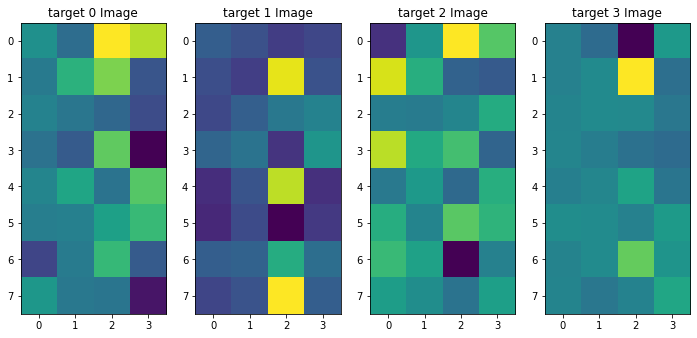

In [ ]:
# Scaling 한 뒤의 이미지
f, a = plt.subplots(1, 4, figsize = (12, 6))
for i in range(4) :
    a[i].set_title(f'target {i} Image')
    a[i].imshow(np.array(gr_mu.iloc[i]).reshape(8, 4))

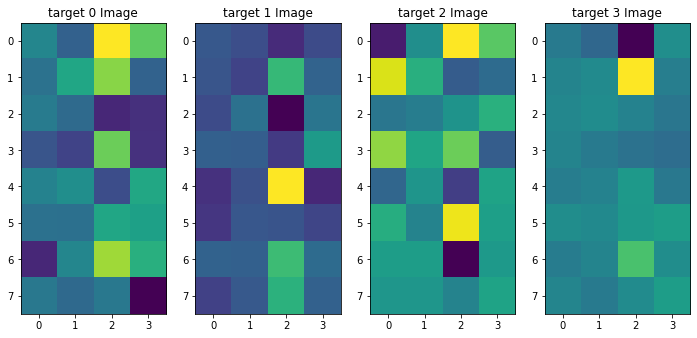

In [ ]:
# 컬럼별로 scaling 한 이미지, 차이없음
f, a = plt.subplots(1, 4, figsize = (12, 6))
for i in range(4) :
    a[i].set_title(f'target {i} Image')
    a[i].imshow(np.array(gr_mu.iloc[i]).reshape(8, 4))

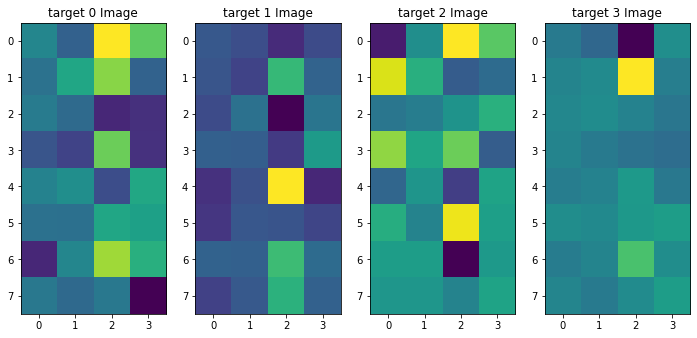

In [ ]:
# 원본 data 이미지
f, a = plt.subplots(1, 4, figsize = (12, 6))
for i in range(4) :
    a[i].set_title(f'target {i} Image')
    a[i].imshow(np.array(gr_mu.iloc[i]).reshape(8, 4))

비록 통계량을 통해 봤지만 target별로 어느 정도 다른 형태를 띈다고 볼 수 있을 것 같습니다.

### CNN

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')   # train_data
test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')     # test_data
submission = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/sample_submission.csv')

In [ ]:
X = train.iloc[:, 1:-1]     # sensor_1 ~ sensor_32 / [2335, 32]
target = test.iloc[:, 1:]   # sensor_1 ~ sensor_32 / [9343, 32]

### 8 * 8 로 진행, 기존 컬럼 복사후 추가 (홀수, 짝수 순서로 배치) -> 성능 0.01~0.02감소

In [ ]:
# column 작업
col_list = list(train.columns[1:-1])

In [ ]:
# 8 * 8 작업 시작 

for i in range(0, len(col_list), 2):
    new = f'copy_{col_list[i]}'
    X[new] = X[col_list[i]]

for i in range(1, len(col_list), 2):
    new = f'copy_{col_list[i]}'
    X[new] = X[col_list[i]]

for i in range(0, len(col_list), 2):
    new = f'copy_{col_list[i]}'
    target[new] = target[col_list[i]]

for i in range(1, len(col_list), 2):
    new = f'copy_{col_list[i]}'
    target[new] = target[col_list[i]]

In [ ]:
X.shape, target.shape

((2335, 64), (9343, 64))

In [ ]:
X = np.array(X).reshape(-1, 8, 8, 1)                # [2335, 8, 8, 1]
target = np.array(target).reshape(-1, 8, 8, 1)      # [9343, 8, 8, 1]

In [ ]:
ohe = OneHotEncoder(sparse = False)
y = ohe.fit_transform(train[['target']])    # [2335, 4]
skf = StratifiedShuffleSplit(n_splits=10, train_size=0.9, test_size=0.1, random_state=2022)
es = EarlyStopping(monitor = 'val_acc', patience = 10, mode = 'auto', verbose = 1)  

In [ ]:
record_list = list()

for i in range(10):
    cnn_acc = []
    cnn_pred = np.zeros((target.shape[0], 4))   # [9343, 4]

    dim_3_3 = 64
    dim_1_1 = 16

    for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
        print(f'{i + 1} Fold Training.....')
        tr_x, tr_y = X[tr_idx], y[tr_idx]
        val_x, val_y = X[val_idx], y[val_idx]
        
        ### CNN 모델
        cnn = Sequential([
                        Conv2D(dim_3_3, (2, 2), padding = "same", activation = 'relu', input_shape = (8, 8, 1)),
                        BatchNormalization(),
                        Conv2D(dim_1_1, (1, 1), padding = "same", activation = 'relu'),
                        BatchNormalization(),
                        Conv2D(dim_3_3, (3, 3), padding = "same", activation = 'relu'),
                        
                        BatchNormalization(),
                        Conv2D(dim_1_1, (1, 1), padding = "same", activation = 'relu'),
                        BatchNormalization(),
                        Conv2D(dim_3_3, (4, 4), padding = "same", activation = 'relu'),
                        BatchNormalization(),
                        GlobalAveragePooling2D(),
                        Dense(32, activation = 'relu'),
                        Dense(4, activation = 'softmax')
                        ])


        ### ModelCheckPoint Fold마다 갱신
        mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'auto', verbose = 0)    # monitor 변경 / val_acc
        
        ### 모델 compile
        cnn.compile(optimizer = RMSprop(learning_rate = 0.0004), loss = 'categorical_crossentropy', metrics = ['acc'])            # optimizer 변경

        cnn.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)

        ### 최고 성능 기록 모델 Load
        best = load_model(f'model_{i + 1}.h5')
        ### validation predict
        val_pred = best.predict(val_x)
        ### 확률값 중 최대값을 클래스로 매칭
        val_cls = np.argmax(val_pred, axis = 1)
        ### Fold별 정확도 산출
        fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
        cnn_acc.append(fold_cnn_acc)
        print(f'{i + 1} Fold ACC of CNN = {fold_cnn_acc}\n')

        ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
        fold_pred = best.predict(target) / skf.n_splits
        # print(fold_pred.shape)
        cnn_pred += fold_pred
    record_list.append(cnn_pred)

In [ ]:
# 결과 확인
print(np.mean(cnn_acc)) 
print(np.argmax(cnn_pred, axis = 1))
cnn_pred

0.8212250712250712
[0 0 1 ... 2 0 3]


array([[5.08947119e-01, 5.83909132e-02, 1.55450002e-02, 1.71169459e-02],
       [5.81250519e-01, 1.20170380e-03, 1.04566648e-02, 7.09109157e-03],
       [1.43235735e-01, 3.96250032e-01, 4.73536392e-02, 1.31606142e-02],
       ...,
       [2.48665687e-01, 1.08799594e-03, 3.20227407e-01, 3.00189140e-02],
       [5.32411419e-01, 1.69093958e-03, 5.49738230e-02, 1.09237978e-02],
       [3.63324184e-04, 1.34211665e-02, 1.56512372e-03, 5.84650390e-01]])

### 다시 진행

sensor1 ~ 32이기 때문에 8 * 4형태로 바꾸어줍니다.

In [ ]:
X = np.array(X).reshape(-1, 8, 4, 1)                # [2335, 8, 4, 1]
target = np.array(target).reshape(-1, 8, 4, 1)      # [9343, 8, 4, 1]

In [ ]:
ohe = OneHotEncoder(sparse = False)
y = ohe.fit_transform(train[['target']])    # [2335, 4]
skf = StratifiedShuffleSplit(n_splits=10, train_size=0.9, test_size=0.1, random_state=2022)
es = EarlyStopping(monitor = 'val_acc', patience = 10, mode = 'max', verbose = 1)  

In [ ]:
new_y = y+0.05

In [ ]:
new_y

array([[0.05, 1.05, 0.05, 0.05],
       [0.05, 1.05, 0.05, 0.05],
       [1.05, 0.05, 0.05, 0.05],
       ...,
       [0.05, 0.05, 0.05, 1.05],
       [0.05, 1.05, 0.05, 0.05],
       [0.05, 0.05, 1.05, 0.05]])

In [ ]:
new_y2 = new_y/(1.2)
new_y2

array([[0.04166667, 0.875     , 0.04166667, 0.04166667],
       [0.04166667, 0.875     , 0.04166667, 0.04166667],
       [0.875     , 0.04166667, 0.04166667, 0.04166667],
       ...,
       [0.04166667, 0.04166667, 0.04166667, 0.875     ],
       [0.04166667, 0.875     , 0.04166667, 0.04166667],
       [0.04166667, 0.04166667, 0.875     , 0.04166667]])

In [ ]:
y = new_y2

In [ ]:
record_list = list()

for i in range(10):
    print(f'{i+1}/10 진행중입니다')
    cnn_acc = []
    cnn_pred = np.zeros((target.shape[0], 4))   # [9343, 4]

    dim_3_3 = 64
    dim_1_1 = 16

    for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
        print(f'{i + 1} Fold Training.....')
        tr_x, tr_y = X[tr_idx], y[tr_idx]
        val_x, val_y = X[val_idx], y[val_idx]
        
        ### CNN 모델
        cnn = Sequential([
                        Conv2D(dim_3_3, (2, 2), padding = "same", activation = 'relu', input_shape = (8, 4, 1)),
                        BatchNormalization(),
                        Conv2D(dim_1_1, (1, 1), padding = "same", activation = 'relu'),
                        BatchNormalization(),
                        Conv2D(dim_3_3, (3, 3), padding = "same", activation = 'relu'),
                        
                        BatchNormalization(),
                        Conv2D(dim_1_1, (1, 1), padding = "same", activation = 'relu'),
                        BatchNormalization(),
                        Conv2D(dim_3_3, (4, 4), padding = "same", activation = 'relu'),
                        BatchNormalization(),
                        GlobalAveragePooling2D(),
                        Dense(32, activation = 'relu'),
                        Dense(4, activation = 'softmax')
                        ])


        ### ModelCheckPoint Fold마다 갱신
        mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'auto', verbose = 0)    # monitor 변경 / val_acc
        
        ### 모델 compile
        cnn.compile(optimizer = RMSprop(learning_rate = 0.0004), loss = 'categorical_crossentropy', metrics = ['acc'])            # optimizer 변경

        cnn.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)

        ### 최고 성능 기록 모델 Load
        best = load_model(f'model_{i + 1}.h5')
        ### validation predict
        val_pred = best.predict(val_x)
        ### 확률값 중 최대값을 클래스로 매칭
        val_cls = np.argmax(val_pred, axis = 1)
        ### Fold별 정확도 산출
        fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
        cnn_acc.append(fold_cnn_acc)
        print(f'{i + 1} Fold ACC of CNN = {fold_cnn_acc}\n')

        ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
        fold_pred = best.predict(target) / skf.n_splits
        # print(fold_pred.shape)
        cnn_pred += fold_pred
    record_list.append(cnn_pred)

In [ ]:
my_pred = record_list[0]/10

for i in range(1,len(record_list)):
    print(f'plus {i}fold ')
    my_pred += record_list[i]/10

plus 1fold 
plus 2fold 
plus 3fold 
plus 4fold 
plus 5fold 
plus 6fold 
plus 7fold 
plus 8fold 
plus 9fold 


In [ ]:
print(np.mean(cnn_acc)) 
print(np.argmax(my_pred, axis = 1))
cnn_pred

0.8662393162393162
[0 0 1 ... 2 0 3]


array([[0.78538086, 0.08906532, 0.08924829, 0.03630554],
       [0.94214831, 0.01686185, 0.02038543, 0.02060441],
       [0.16892321, 0.68195624, 0.09893249, 0.05018805],
       ...,
       [0.3993178 , 0.04568033, 0.50079612, 0.05420573],
       [0.89162979, 0.02428242, 0.04331379, 0.04077401],
       [0.04146276, 0.07944161, 0.03484253, 0.8442531 ]])

In [ ]:
# record_list = list()

In [ ]:
record_list.append(cnn_pred)

In [ ]:
weights = np.array([1, 1, 0.99, 0.99])

In [ ]:
my_pred = weights * record_list[2]

In [ ]:
# 위의 Resnet 구조 logit 과 CNN 앙상블
new_ensemble = my_pred + cnn_result1
new_ensemble

array([[1.59314849, 0.15393089, 0.16543165, 0.0874889 ],
       [1.81523049, 0.06269947, 0.06093513, 0.06113485],
       [0.26838858, 1.45012725, 0.1362533 , 0.14523083],
       ...,
       [0.57402604, 0.0949234 , 1.23021353, 0.10083706],
       [1.76260784, 0.06566738, 0.09230978, 0.07941499],
       [0.08076694, 0.11345679, 0.07802542, 1.72775087]])

In [ ]:
# 결과확인
submission['target'] = np.argmax(my_pred, axis = 1)
submission.target.value_counts()



1    2496
2    2429
0    2276
3    2142
Name: target, dtype: int64

In [ ]:
submission.to_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_5.csv', index = False)

In [ ]:
submission.to_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_17.csv', index = False)

In [ ]:
second_id = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_3.csv')
first_id = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_12.csv')

In [ ]:
first_id

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
...,...,...
9338,9339,3
9339,9340,1
9340,9341,2
9341,9342,0


In [ ]:
first_id[first_id['target']!=second_id['target']]

,id,target
2766,2767,1
5024,5025,0
5486,5487,1
5620,5621,1
7047,7048,0
8132,8133,1


In [ ]:
second_id[first_id['target']!=second_id['target']]

,id,target
2766,2767,2
5024,5025,2
5486,5487,3
5620,5621,3
7047,7048,2
8132,8133,2


In [ ]:
# seed 1
'''
2    2535
1    2464
3    2293
0    2051
'''

# seed 2
'''
2    2450
1    2390
3    2384
0    2119
'''

# seed 3
'''
3    2447
2    2437
1    2263
0    2196
'''

# seed 4
'''
3    2445
2    2433
1    2267
0    2198
'''

In [ ]:
ensemble_pred = (record_list[0]+record_list[1]) / 2
submission['target'] = np.argmax(ensemble_pred, axis = 1)
submission.target.value_counts()

### 코드공유 0.89xx

In [ ]:
dim_3_3 = 64
dim_1_1 = 16

model1 = Sequential([
                    Conv2D(dim_3_3, (2, 2), padding = "same", activation = 'relu', input_shape = (8, 4, 1)),
                    BatchNormalization(),
                    Conv2D(dim_1_1, (1, 1), padding = "same", activation = 'relu'),
                    BatchNormalization(),
                    Conv2D(dim_3_3, (3, 3), padding = "same", activation = 'relu'),
                    MaxPooling2D(2, 2),
                    BatchNormalization(),
                    Conv2D(dim_1_1, (1, 1), padding = "same", activation = 'relu'),
                    BatchNormalization(),
                    Conv2D(dim_3_3, (4, 4), padding = "same", activation = 'relu'),
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(32, activation = 'relu'),
                    Dense(4, activation = 'softmax')
                    ])

In [ ]:
dim_3_3 = 64
dim_1_1 = 16

model2 = Sequential([
                    Conv2D(dim_3_3, (2, 2), padding = "same", activation = 'relu', input_shape = (8, 4, 1)),
                    BatchNormalization(),
                    Conv2D(dim_1_1, (1, 1), padding = "same", activation = 'relu'),
                    BatchNormalization(),
                    Conv2D(dim_3_3, (3, 3), padding = "same", activation = 'relu'),
                    
                    BatchNormalization(),
                    Conv2D(dim_1_1, (1, 1), padding = "same", activation = 'relu'),
                    BatchNormalization(),
                    Conv2D(dim_3_3, (4, 4), padding = "same", activation = 'relu'),
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(32, activation = 'relu'),
                    Dense(4, activation = 'softmax')
                    ])

### 4 * 8 형태로 Test

In [ ]:
X = np.array(X).reshape(-1, 4, 8, 1)                # [2335, 4, 8, 1]
target = np.array(target).reshape(-1, 4, 8, 1)  

MultiClass를 위해 target 값에 One-Hot 인코딩을 취해줍니다.

In [ ]:
ohe = OneHotEncoder(sparse = False)

In [ ]:
y = ohe.fit_transform(train[['target']])    # [2335, 4]

In [ ]:
# skf = StratifiedKFold(n_splits = 8, random_state = 2022, shuffle = True)  # 8로 해줌
skf = StratifiedShuffleSplit(n_splits=10, train_size=0.9, test_size=0.1, random_state=2022)

In [ ]:
es = EarlyStopping(monitor = 'val_acc', patience = 10, mode = 'max', verbose = 1)    # val_loss로 바꿔줄 수도 있고,

In [ ]:
cnn_acc = []
cnn_pred = np.zeros((target.shape[0], 4))   # [9343, 4]

dim_3_3 = 64
dim_1_1 = 16

drop_rate = 0.2

for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### CNN 모델
    cnn = Sequential()
    cnn.add(Conv2D(64, (2, 2), padding = "same", activation = 'relu', input_shape = (8, 4, 1)))  # 8  # 'elu' , 'relu'
    # cnn.add(Dropout(drop_rate))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (2, 2), padding = "same", activation = 'relu'))  #16
    cnn.add(MaxPooling2D(2, 2))
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(GlobalAveragePooling2D())
    cnn.add(Dense(16, activation = 'relu'))   # kernel_initializer 사용해보기, defualt는 xavier라는데..kernel_initializer='initializer',
    cnn.add(Dropout(drop_rate))
    cnn.add(Dense(4, activation = 'softmax'))


    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'auto', verbose = 0)    # monitor 변경 / val_acc
    
    ### 모델 compile
    cnn.compile(optimizer = RMSprop(learning_rate = 0.04), loss = 'categorical_crossentropy', metrics = ['acc'])            # optimizer 변경

    cnn.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f'{i + 1} Fold ACC of CNN = {fold_cnn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(target) / skf.n_splits
    # print(fold_pred.shape)
    cnn_pred += fold_pred

In [ ]:
print(np.mean(cnn_acc)) # 0.84444
print(np.argmax(cnn_pred, axis = 1))
cnn_pred

0.8444444444444443
[0 0 1 ... 0 0 3]


array([[9.93563570e-01, 1.16060878e-03, 4.94381169e-03, 3.32004819e-04],
       [9.98445906e-01, 3.05886653e-06, 8.48156917e-04, 7.02856285e-04],
       [2.84471357e-01, 6.33774012e-01, 4.05850875e-02, 4.11695522e-02],
       ...,
       [5.07374829e-01, 2.63022034e-04, 4.91151799e-01, 1.21035215e-03],
       [9.99310009e-01, 1.61188842e-06, 6.10174624e-04, 7.82201427e-05],
       [9.05450041e-09, 8.87879496e-06, 1.54796221e-05, 9.99975644e-01]])

In [ ]:
submission['target'] = np.argmax(cnn_pred, axis = 1)
submission.target.value_counts()

3    2488
2    2406
0    2341
1    2108
Name: target, dtype: int64

### 6 * 6 형태로 만들고 Test -> 실패

In [ ]:
# column 작업
col_list = list(train.columns[1:-1])
first_col = col_list[0:4]
second_col = col_list[4:10]
third_col = col_list[10:16]
fourth_col = col_list[16:22]
fifth_col = col_list[22:28]
sixth_col = col_list[28:32]

# fake sensor
fake_sensor_2 = [float(-150) for i in range(2335)]
fake_sensor_3 = [float(-150) for i in range(2335)]
fake_sensor_4 = [float(-150) for i in range(2335)]

In [ ]:
my_train = pd.DataFrame({'fake_sensor_1':[float(-150) for i in range(2335)], })

for i in first_col:
    my_train[i] = train[i]

my_train['fake_sensor_2'] = fake_sensor_2

for i in col_list[4:28]:
    my_train[i] = train[i]

my_train['fake_sensor_3'] = fake_sensor_3

for i in sixth_col:
    my_train[i] = train[i]

my_train['fake_sensor_4'] = fake_sensor_4

In [ ]:
my_train['target'] = train['target']

In [ ]:
my_train

,fake_sensor_1,sensor_1,sensor_2,sensor_3,sensor_4,fake_sensor_2,sensor_5,sensor_6,sensor_7,sensor_8,...,sensor_26,sensor_27,sensor_28,fake_sensor_3,sensor_29,sensor_30,sensor_31,sensor_32,fake_sensor_4,target
0,-150.0,-6.149463,-0.929714,9.058368,-7.017854,-150.0,-2.958471,0.179233,-0.956591,-0.972401,...,-6.005836,7.043084,21.884650,-150.0,-3.064152,-5.247552,-6.026107,-11.990822,-150.0,1
1,-150.0,-2.238836,-1.003511,5.098079,-10.880357,-150.0,-0.804562,-2.992123,26.972724,-8.900861,...,-3.136773,8.774211,10.944759,-150.0,9.858186,-0.969241,-3.935553,-15.892421,-150.0,1
2,-150.0,19.087934,-2.092514,0.946750,-21.831788,-150.0,9.119235,17.853587,-21.069954,-15.933212,...,-6.109238,12.154595,6.095989,-150.0,-40.195088,-3.958124,-8.079537,-5.160090,-150.0,0
3,-150.0,-2.211629,-1.930904,21.888406,-3.067560,-150.0,-0.240634,2.985056,-29.073369,0.200774,...,2.178769,10.032723,-1.010897,-150.0,-3.912848,-2.980338,-12.983597,-3.001077,-150.0,1
4,-150.0,3.953852,2.964892,-36.044802,0.899838,-150.0,26.930210,11.004409,-21.962423,-11.950189,...,1.905335,-13.004707,17.169552,-150.0,2.105194,3.967986,11.861657,-27.088846,-150.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,-150.0,-3.971043,39.913391,16.034626,-19.067697,-150.0,8.061361,-70.916786,-39.937026,12.834223,...,-11.106802,-37.863399,31.069292,-150.0,-4.097017,-13.095192,-5.150284,8.016265,-150.0,3
2331,-150.0,-3.011710,-4.060355,-1.046067,4.178137,-150.0,-2.003243,-2.895017,-2.766757,-29.099123,...,-0.867018,23.892336,-11.977934,-150.0,1.984203,0.891666,28.822082,-0.878670,-150.0,3
2332,-150.0,-9.001824,5.985711,-8.146347,-10.902201,-150.0,5.102105,8.133692,32.877614,-3.017438,...,-5.825790,-37.989569,15.014132,-150.0,1.160272,-11.135889,-7.035763,-0.930067,-150.0,3
2333,-150.0,-3.987992,3.011460,-11.949323,-3.810885,-150.0,16.880234,-5.150117,9.182801,4.960190,...,-1.052350,-6.019488,-7.075333,-150.0,-5.826058,-3.989168,14.916905,-12.093426,-150.0,1


In [ ]:
my_test = pd.DataFrame({'fake_sensor_1':[float(-150) for i in range(2335)], })

for i in first_col:
    my_test[i] = test[i]

my_test['fake_sensor_2'] = fake_sensor_2

for i in col_list[4:28]:
    my_test[i] = test[i]

my_test['fake_sensor_3'] = fake_sensor_3

for i in sixth_col:
    my_test[i] = test[i]

my_test['fake_sensor_4'] = fake_sensor_4

In [ ]:
my_test

,fake_sensor_1,sensor_1,sensor_2,sensor_3,sensor_4,fake_sensor_2,sensor_5,sensor_6,sensor_7,sensor_8,...,sensor_25,sensor_26,sensor_27,sensor_28,fake_sensor_3,sensor_29,sensor_30,sensor_31,sensor_32,fake_sensor_4
0,-150.0,0.067135,5.040383,-2.965405,-12.952880,-150.0,-1.938465,-10.997802,1.853669,21.077862,...,1.889536,-3.926719,0.929041,4.999071,-150.0,-7.963270,4.044370,-1.993315,10.855771,-150.0
1,-150.0,6.890655,-12.010728,24.881907,38.943245,-150.0,-4.757496,5.926453,7.923851,3.925545,...,-16.940167,-11.169073,0.202975,6.846631,-150.0,7.911875,-2.852819,56.028042,52.967175,-150.0
2,-150.0,-4.809695,0.962863,-1.893647,-6.168084,-150.0,-3.948282,0.977219,12.960620,-9.048958,...,-0.025761,2.981749,4.948704,-10.841968,-150.0,-4.860024,-6.917495,2.842422,-3.081374,-150.0
3,-150.0,0.018158,-3.993114,12.001667,22.960746,-150.0,-2.121793,-6.002385,2.173744,1.045248,...,0.903349,5.156367,40.827713,-1.160840,-150.0,-1.215552,0.037914,-24.968873,-7.148603,-150.0
4,-150.0,-7.841592,-2.129997,7.872448,-8.953428,-150.0,28.080007,-5.019895,-10.922551,-15.045833,...,-6.741350,0.831967,11.905613,3.106004,-150.0,46.899363,3.001353,-17.881074,-6.882390,-150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,-150.0,9.007669,-14.948836,67.104083,37.138699,-150.0,4.054303,1.988841,18.987299,4.132425,...,-0.098956,-4.054819,-6.938961,1.132044,-150.0,19.988916,-7.074481,7.190388,-3.128530,-150.0
2331,-150.0,-2.968922,-4.089736,13.886262,10.186835,-150.0,-2.074601,2.900731,-6.881137,-1.773111,...,0.850097,10.033898,-6.909573,9.074467,-150.0,-1.104329,-2.085449,-0.925846,-27.979877,-150.0
2332,-150.0,0.134404,-2.926897,6.165142,-10.027785,-150.0,-2.093082,0.921323,-1.065012,-4.943164,...,-0.906695,-2.023843,-10.046798,-0.896529,-150.0,-1.951230,-2.907241,5.085105,-3.998271,-150.0
2333,-150.0,-2.011020,-2.981342,-1.833128,-1.985822,-150.0,0.033427,-7.098391,-5.901165,-4.069867,...,2.138403,1.991783,0.184541,-5.127206,-150.0,-1.980014,-13.846111,-10.911780,2.130143,-150.0


In [ ]:
gr_mu = my_train.groupby('target').mean().iloc[:, :]

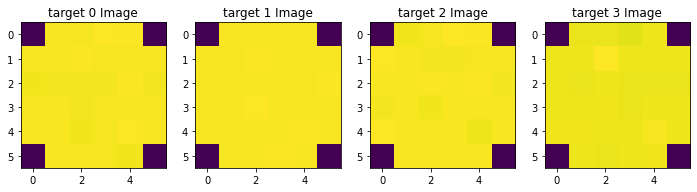

In [ ]:
f, a = plt.subplots(1, 4, figsize = (12, 6))
for i in range(4) :
    a[i].set_title(f'target {i} Image')
    a[i].imshow(np.array(gr_mu.iloc[i]).reshape(6, 6))

In [ ]:
X = my_train.iloc[:, :-1]
target = my_test.iloc[:, :]

In [ ]:
X = np.array(X).reshape(-1, 6, 6, 1)                # [2335, 6, 6, 1]
target = np.array(target).reshape(-1, 6, 6, 1)      # [9343, 6, 6, 1]

In [ ]:
ohe = OneHotEncoder(sparse = False)
y = ohe.fit_transform(train[['target']])
skf = StratifiedKFold(n_splits = 8, random_state = 2022, shuffle = True)
es = EarlyStopping(monitor = 'val_acc', patience = 10, mode = 'max', verbose = 1) 

In [ ]:
cnn_acc = []
cnn_pred = np.zeros((target.shape[0], 4))   # [9343, 4]

dim_3_3 = 64
dim_1_1 = 16

drop_rate = 0.2

for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### CNN 모델
    cnn = Sequential()
    cnn.add(Conv2D(16, (2, 2), padding = "same", activation = 'relu', input_shape = (6, 6, 1)))  # 8  # 'elu' , 'relu'
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (2, 2), padding = "same", activation = 'relu'))  #16
    cnn.add(MaxPooling2D(2, 2))
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(GlobalAveragePooling2D())
    cnn.add(Dense(16, activation = 'relu'))   # kernel_initializer 사용해보기, defualt는 xavier라는데..kernel_initializer='initializer',
    cnn.add(Dropout(drop_rate))
    cnn.add(Dense(4, activation = 'softmax'))


    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'auto', verbose = 0)    # monitor 변경 / val_acc
    
    ### 모델 compile
    cnn.compile(optimizer = RMSprop(learning_rate = 0.04), loss = 'categorical_crossentropy', metrics = ['acc'])            # optimizer 변경

    cnn.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f'{i + 1} Fold ACC of CNN = {fold_cnn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(target) / skf.n_splits
    # print(fold_pred.shape)
    cnn_pred += fold_pred

### 8 * 8 로 진행, 기존 컬럼 복사후 추가 (홀수, 짝수 순서로 배치) -> 성능 0.01~0.02감소

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/sample_submission.csv')

In [ ]:
# column 작업
col_list = list(train.columns[1:-1])

In [ ]:
X = train.iloc[:, 1:-1]     # sensor_1 ~ sensor_32 / [2335, 32]
target = test.iloc[:, 1:]   # sensor_1 ~ sensor_32 / [9343, 32]

In [ ]:
# 8 * 8 작업 시작 

for i in range(0, len(col_list), 2):
    new = f'copy_{col_list[i]}'
    X[new] = X[col_list[i]]

for i in range(1, len(col_list), 2):
    new = f'copy_{col_list[i]}'
    X[new] = X[col_list[i]]

for i in range(0, len(col_list), 2):
    new = f'copy_{col_list[i]}'
    target[new] = target[col_list[i]]

for i in range(1, len(col_list), 2):
    new = f'copy_{col_list[i]}'
    target[new] = target[col_list[i]]

In [ ]:
X.shape, target.shape

((2335, 64), (9343, 64))

In [ ]:
X = np.array(X).reshape(-1, 8, 8, 1)                # [2335, 8, 8, 1]
target = np.array(target).reshape(-1, 8, 8, 1)      # [9343, 8, 8, 1]

In [ ]:
ohe = OneHotEncoder(sparse = False)

In [ ]:
y = ohe.fit_transform(train[['target']])    # [2335, 4]

In [ ]:
skf = StratifiedShuffleSplit(n_splits=10, train_size=0.9, test_size=0.1, random_state=2022)

In [ ]:
es = EarlyStopping(monitor = 'val_acc', patience = 10, mode = 'auto', verbose = 1)  

In [ ]:
cnn_acc = []
cnn_pred = np.zeros((target.shape[0], 4))   # [9343, 4]

drop_rate = 0.2 # 0.2~ 0.5

for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### CNN 모델
    cnn = Sequential()
    cnn.add(Conv2D(128, (2, 2), padding = "same", activation = 'relu', input_shape = (8, 8, 1)))  # 8, (2,2)  # 'elu' , 'relu'
    # cnn.add(Dropout(drop_rate))   #추가
    cnn.add(BatchNormalization())  # cnn.add(BatchNormalization()) / cnn.add(LayerNormalization())
    cnn.add(Conv2D(64, (2, 2), padding = "same", activation = 'relu'))  #16
    # cnn.add(BatchNormalization())   # 추가
    cnn.add(MaxPooling2D(2, 2))
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'relu'))
    cnn.add(BatchNormalization())  # cnn.add(BatchNormalization()) , cnn.add(LayerNormalization())
    cnn.add(GlobalAveragePooling2D())
    cnn.add(Dense(128, activation = 'relu'))   #origin=16, # kernel_initializer 사용해보기, defualt는 xavier라는데..kernel_initializer='initializer',
    # cnn.add(Dropout(drop_rate))
    cnn.add(Dense(4, activation = 'softmax'))


    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'auto', verbose = 1)    # monitor 변경 / val_acc
    
    ### 모델 compile
    opt = Adam(learning_rate=0.001) #RMSprop(learning_rate = 0.04)
    cnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['acc'])

    batch_size = 32 # 32
    cnn.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = batch_size, callbacks = [es, mc], verbose = 1) 

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f'{i + 1} Fold ACC of CNN = {fold_cnn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(target) / skf.n_splits
    # print(fold_pred.shape)
    cnn_pred += fold_pred

In [ ]:
submission['target'] = np.argmax(cnn_pred, axis = 1)
submission.target.value_counts()

0    2511
1    2494
2    2271
3    2067
Name: target, dtype: int64

### 데이터 전처리에서, 절댓값 + 4제곱 루트 + min max(0,1) 분포로 확인

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/sample_submission.csv')

In [ ]:
train_X = train.drop(['id', 'target'], axis = 1)
test_X = test.drop(['id'], axis = 1)

In [ ]:
train_target = train.loc[:,['id','target']]

In [ ]:
def pre_proc(x):
    return (abs(x)**(1/4))

In [ ]:
for i in list(train_X.columns):
    train_X[i] = train_X[i].apply(lambda x: pre_proc(x))
    test_X[i] = test_X[i].apply(lambda x: pre_proc(x))

In [ ]:
mins = train_X.min()
maxs = train_X.max()
train_X = (train_X - mins) / (maxs - mins)
test_X = (test_X - mins) / (maxs - mins)

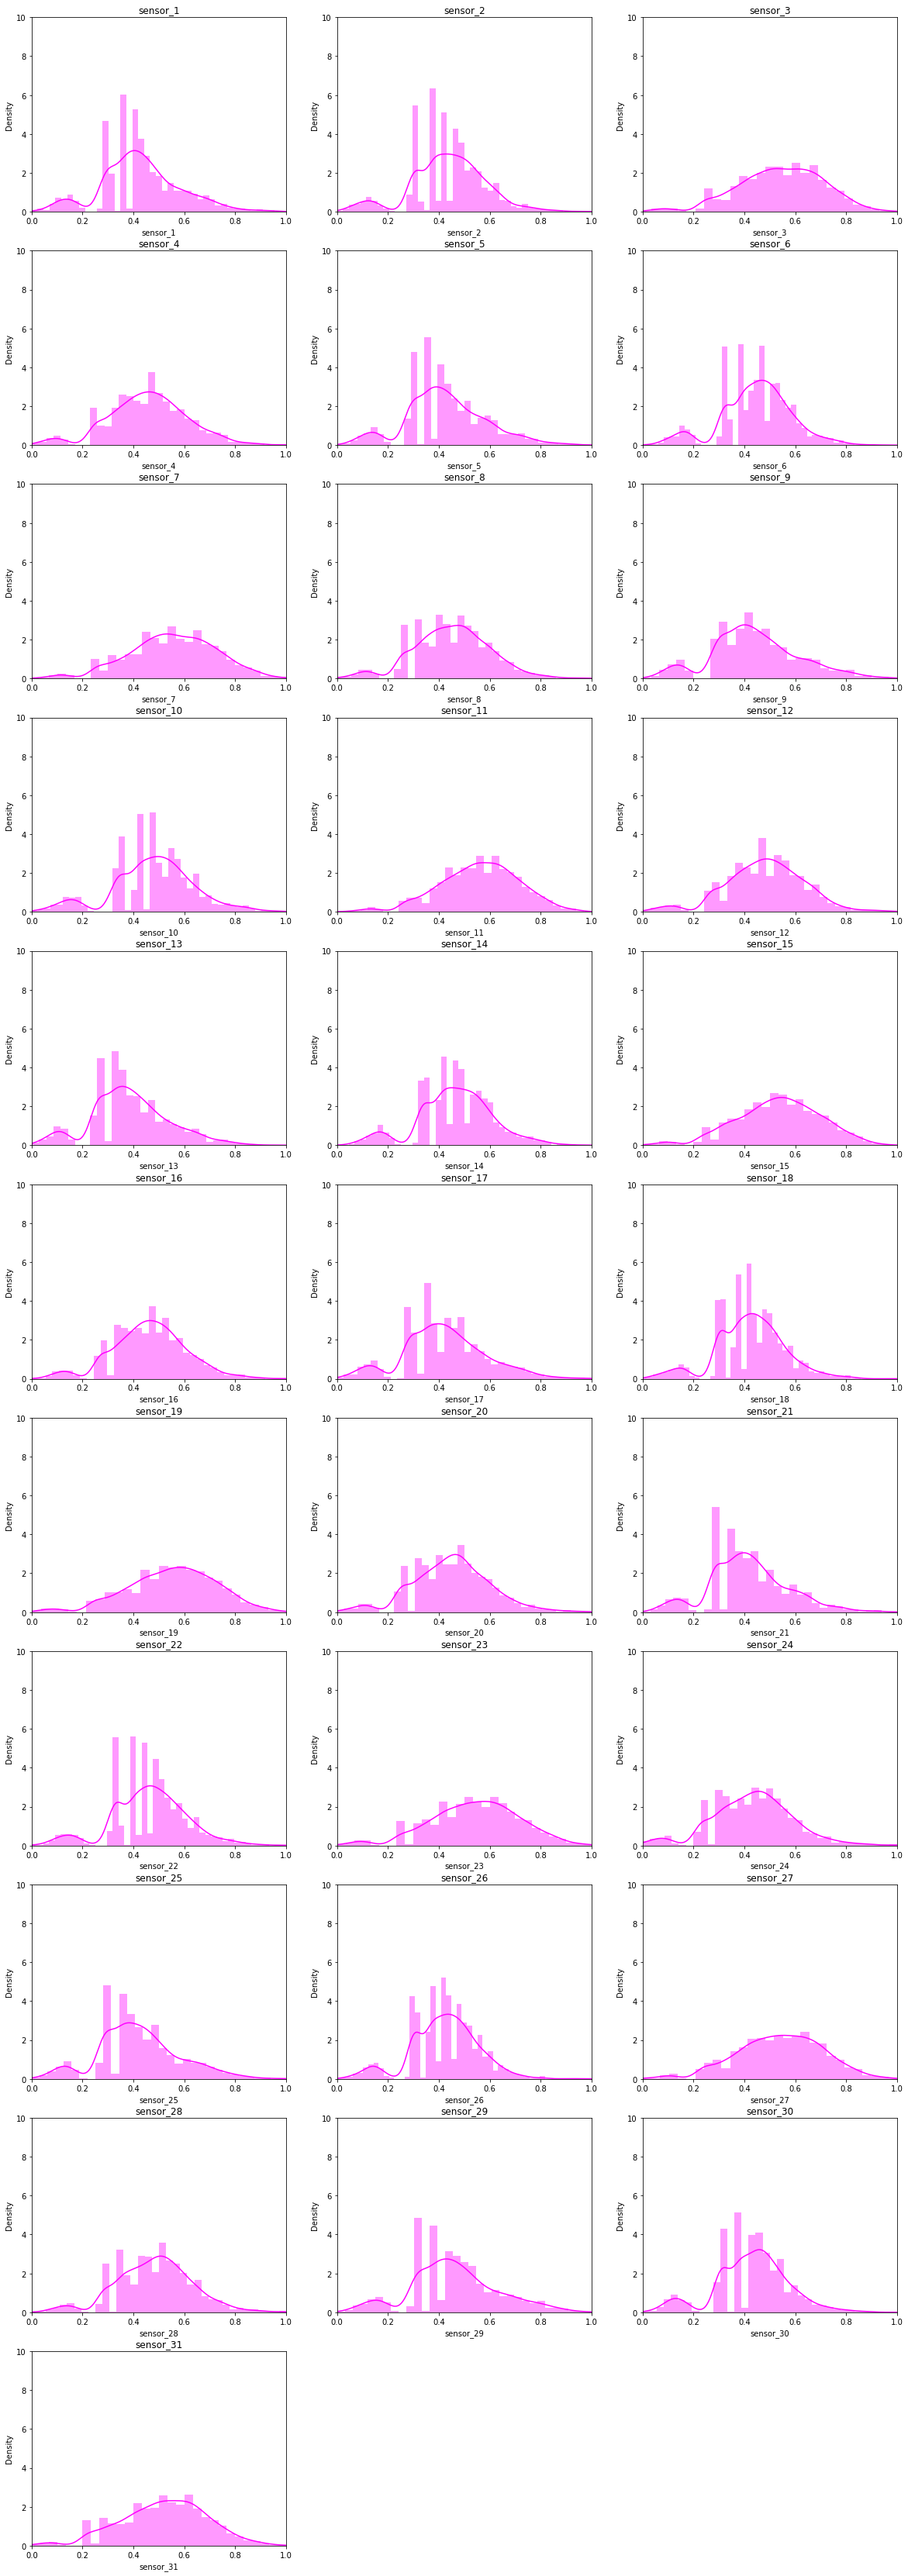

In [ ]:
# 각 센서별 분포그래프 그리기
feature = train_X.columns
plt.figure(figsize=(20,60))

for i in range(len(feature)-1):
    plt.subplot(11,3,i+1)
    plt.title(feature[i])
    plt.xlim(0,1)
    plt.ylim(0,10)
    sns.distplot(train_X[feature[i]],color='magenta')
plt.show()

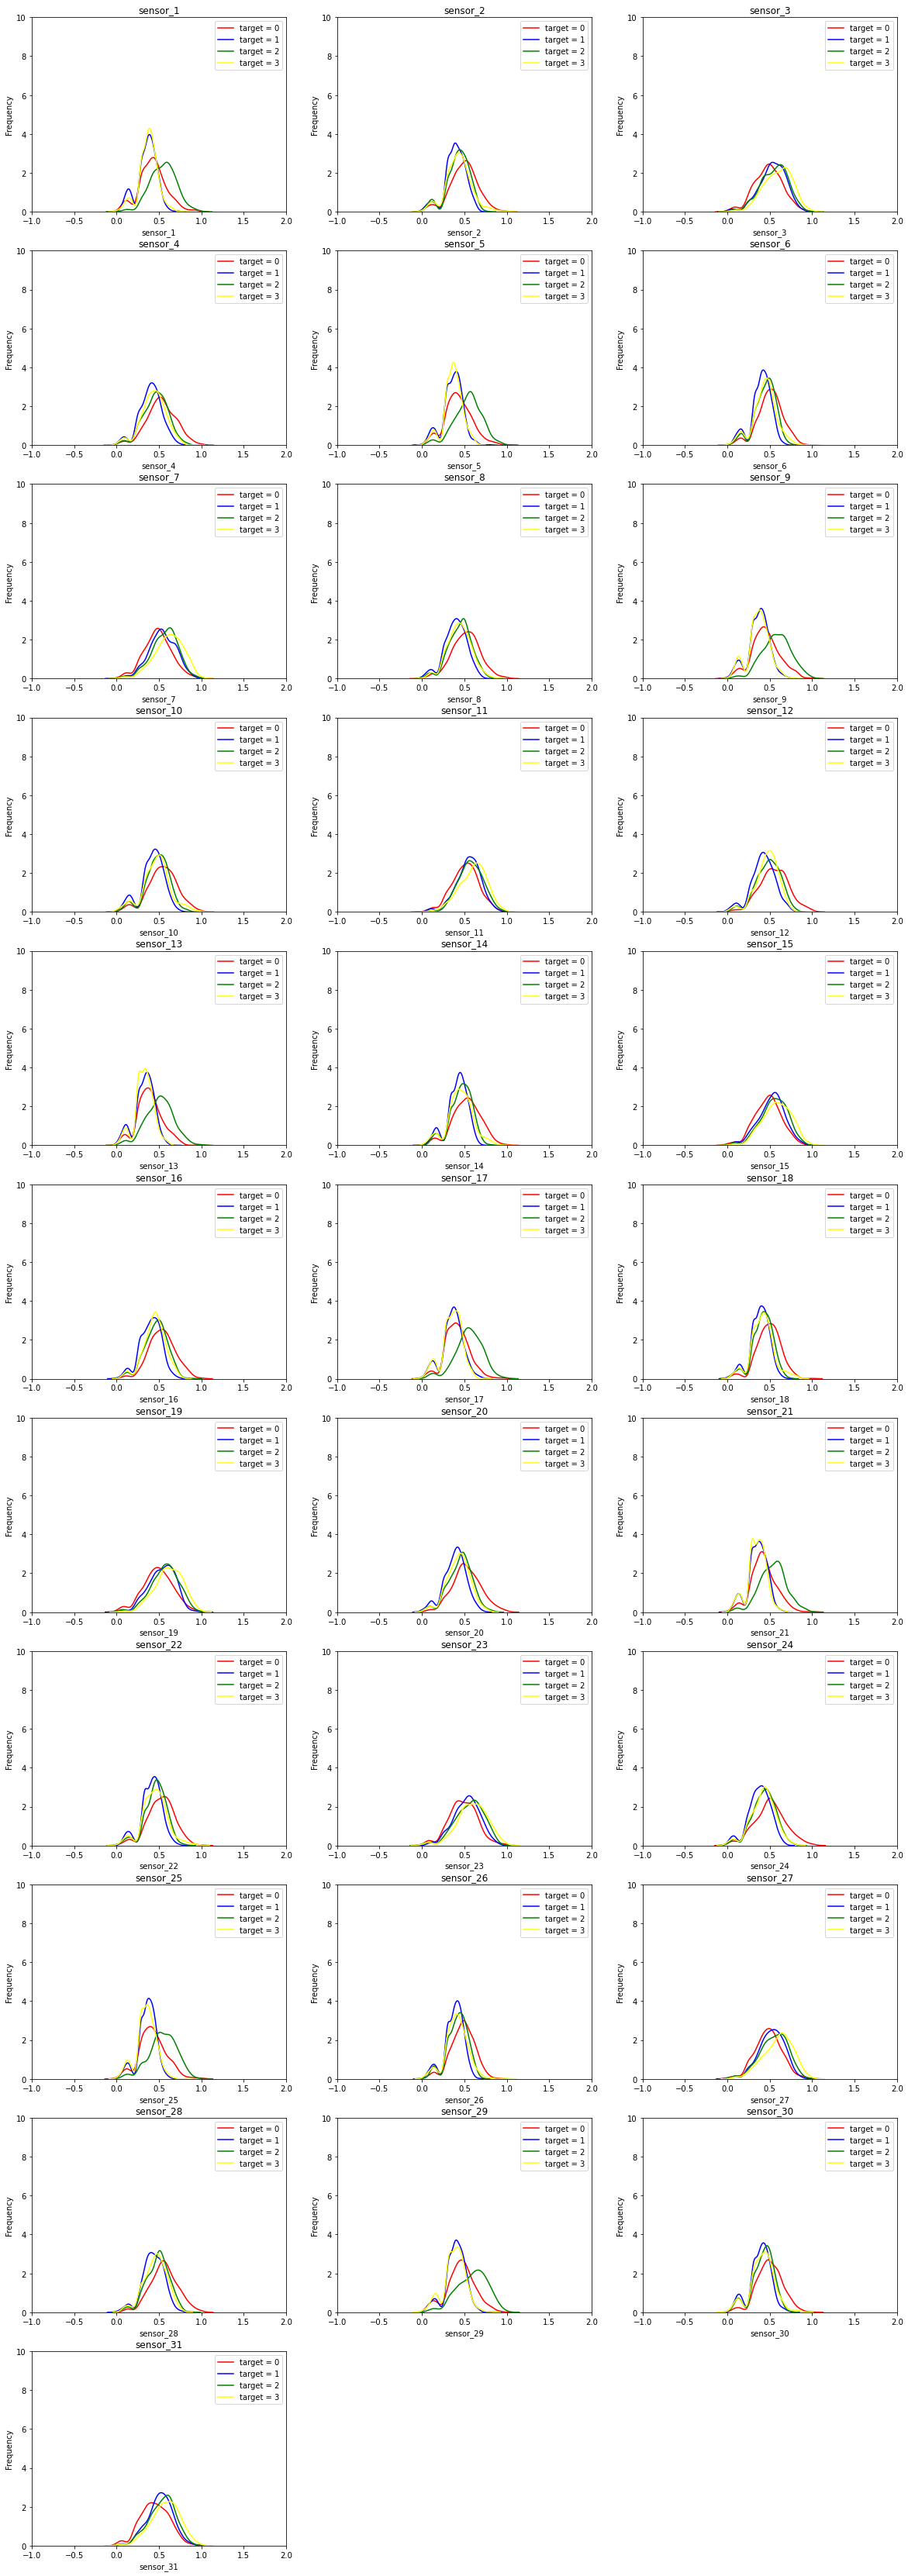

In [ ]:
# 각 센서별 커널밀도함수 그리기
feature = train_X.columns
plt.figure(figsize=(20,60))

for i in range(len(feature)-1):
    plt.subplot(11,3,i+1)
    plt.title(feature[i])

    g = sns.kdeplot(train_X[feature[i]][(train_target['target'] == 0)], color="Red")
    g = sns.kdeplot(train_X[feature[i]][(train_target['target'] == 1)], ax =g, color="Blue")
    g = sns.kdeplot(train_X[feature[i]][(train_target['target'] == 2)], ax =g, color="green")
    g = sns.kdeplot(train_X[feature[i]][(train_target['target'] == 3)], ax =g, color="yellow")

    g.set_xlabel(feature[i])
    g.set_ylabel("Frequency")
    
    plt.xlim(-1,2)
    plt.ylim(0,10)
    g = g.legend(["target = 0","target = 1","target = 2","target = 3"])

plt.show()

### sensor값 역수 취해서 전처리

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')
train_X = train.drop(['id','target'],axis=1)
train_y = train.target

test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')
test_X = test.drop(['id'], axis=1)

In [ ]:
train_X

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
0,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,4.145636,...,-6.066648,-7.026436,-6.006282,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822
1,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,-4.060134,...,14.906205,-1.996714,-7.933806,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421
2,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,-5.975194,...,4.948570,-6.889685,54.052330,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090
3,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,2.099845,...,14.048298,-2.126170,-1.035526,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077
4,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,-4.000506,...,-6.051674,-2.051761,10.917567,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,-3.971043,39.913391,16.034626,-19.067697,8.061361,-70.916786,-39.937026,12.834223,-21.937973,14.942994,...,41.046160,3.086417,-4.954858,-11.106802,-37.863399,31.069292,-4.097017,-13.095192,-5.150284,8.016265
2331,-3.011710,-4.060355,-1.046067,4.178137,-2.003243,-2.895017,-2.766757,-29.099123,-4.208953,-4.793855,...,30.933458,6.871938,-0.134367,-0.867018,23.892336,-11.977934,1.984203,0.891666,28.822082,-0.878670
2332,-9.001824,5.985711,-8.146347,-10.902201,5.102105,8.133692,32.877614,-3.017438,-3.174442,-5.724941,...,57.874418,-7.952857,2.049467,-5.825790,-37.989569,15.014132,1.160272,-11.135889,-7.035763,-0.930067
2333,-3.987992,3.011460,-11.949323,-3.810885,16.880234,-5.150117,9.182801,4.960190,-21.002525,-1.881519,...,-6.008398,3.080276,2.054739,-1.052350,-6.019488,-7.075333,-5.826058,-3.989168,14.916905,-12.093426


In [ ]:
def pre_proc(x):
    if x == 0:
        trans_x = 100
    else:
        trans_x = abs(1/x)
        if trans_x > 100:
            trans_x = 100
    return trans_x

In [ ]:
for i in list(train_X.columns):
    train_X[i] = train_X[i].apply(lambda x: pre_proc(x))

train_X

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
0,0.162616,1.075600,0.110395,0.142494,0.338012,5.579330,1.045379,1.028382,0.167892,0.241218,...,0.164836,0.142320,0.166492,0.166505,0.141983,0.045694,0.326355,0.190565,0.165945,0.083397
1,0.446661,0.996501,0.196152,0.091909,1.242912,0.334211,0.037074,0.112349,0.167552,0.246297,...,0.067086,0.500823,0.126043,0.318799,0.113970,0.091368,0.101439,1.031735,0.254094,0.062923
2,0.052389,0.477894,1.056246,0.045805,0.109658,0.056011,0.047461,0.062762,0.110913,0.167359,...,0.202079,0.145145,0.018501,0.163687,0.082273,0.164042,0.024879,0.252645,0.123769,0.193795
3,0.452155,0.517892,0.045686,0.325992,4.155689,0.335002,0.034396,4.980735,0.958091,0.476226,...,0.071183,0.470329,0.965693,0.458975,0.099674,0.989221,0.255568,0.335532,0.077020,0.333214
4,0.252918,0.337280,0.027743,1.111311,0.037133,0.090873,0.045532,0.083681,0.047770,0.249968,...,0.165244,0.487386,0.091595,0.524842,0.076895,0.058243,0.475016,0.252017,0.084305,0.036916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,0.251823,0.025054,0.062365,0.052445,0.124049,0.014101,0.025039,0.077917,0.045583,0.066921,...,0.024363,0.324000,0.201822,0.090035,0.026411,0.032186,0.244080,0.076364,0.194164,0.124746
2331,0.332037,0.246284,0.955962,0.239341,0.499191,0.345421,0.361434,0.034365,0.237589,0.208600,...,0.032327,0.145519,7.442302,1.153379,0.041854,0.083487,0.503981,1.121497,0.034696,1.138084
2332,0.111089,0.167065,0.122754,0.091725,0.195998,0.122945,0.030416,0.331407,0.315016,0.174674,...,0.017279,0.125741,0.487932,0.171651,0.026323,0.066604,0.861867,0.089800,0.142131,1.075192
2333,0.250753,0.332065,0.083687,0.262406,0.059241,0.194170,0.108899,0.201605,0.047613,0.531486,...,0.166434,0.324646,0.486680,0.950254,0.166127,0.141336,0.171643,0.250679,0.067038,0.082690


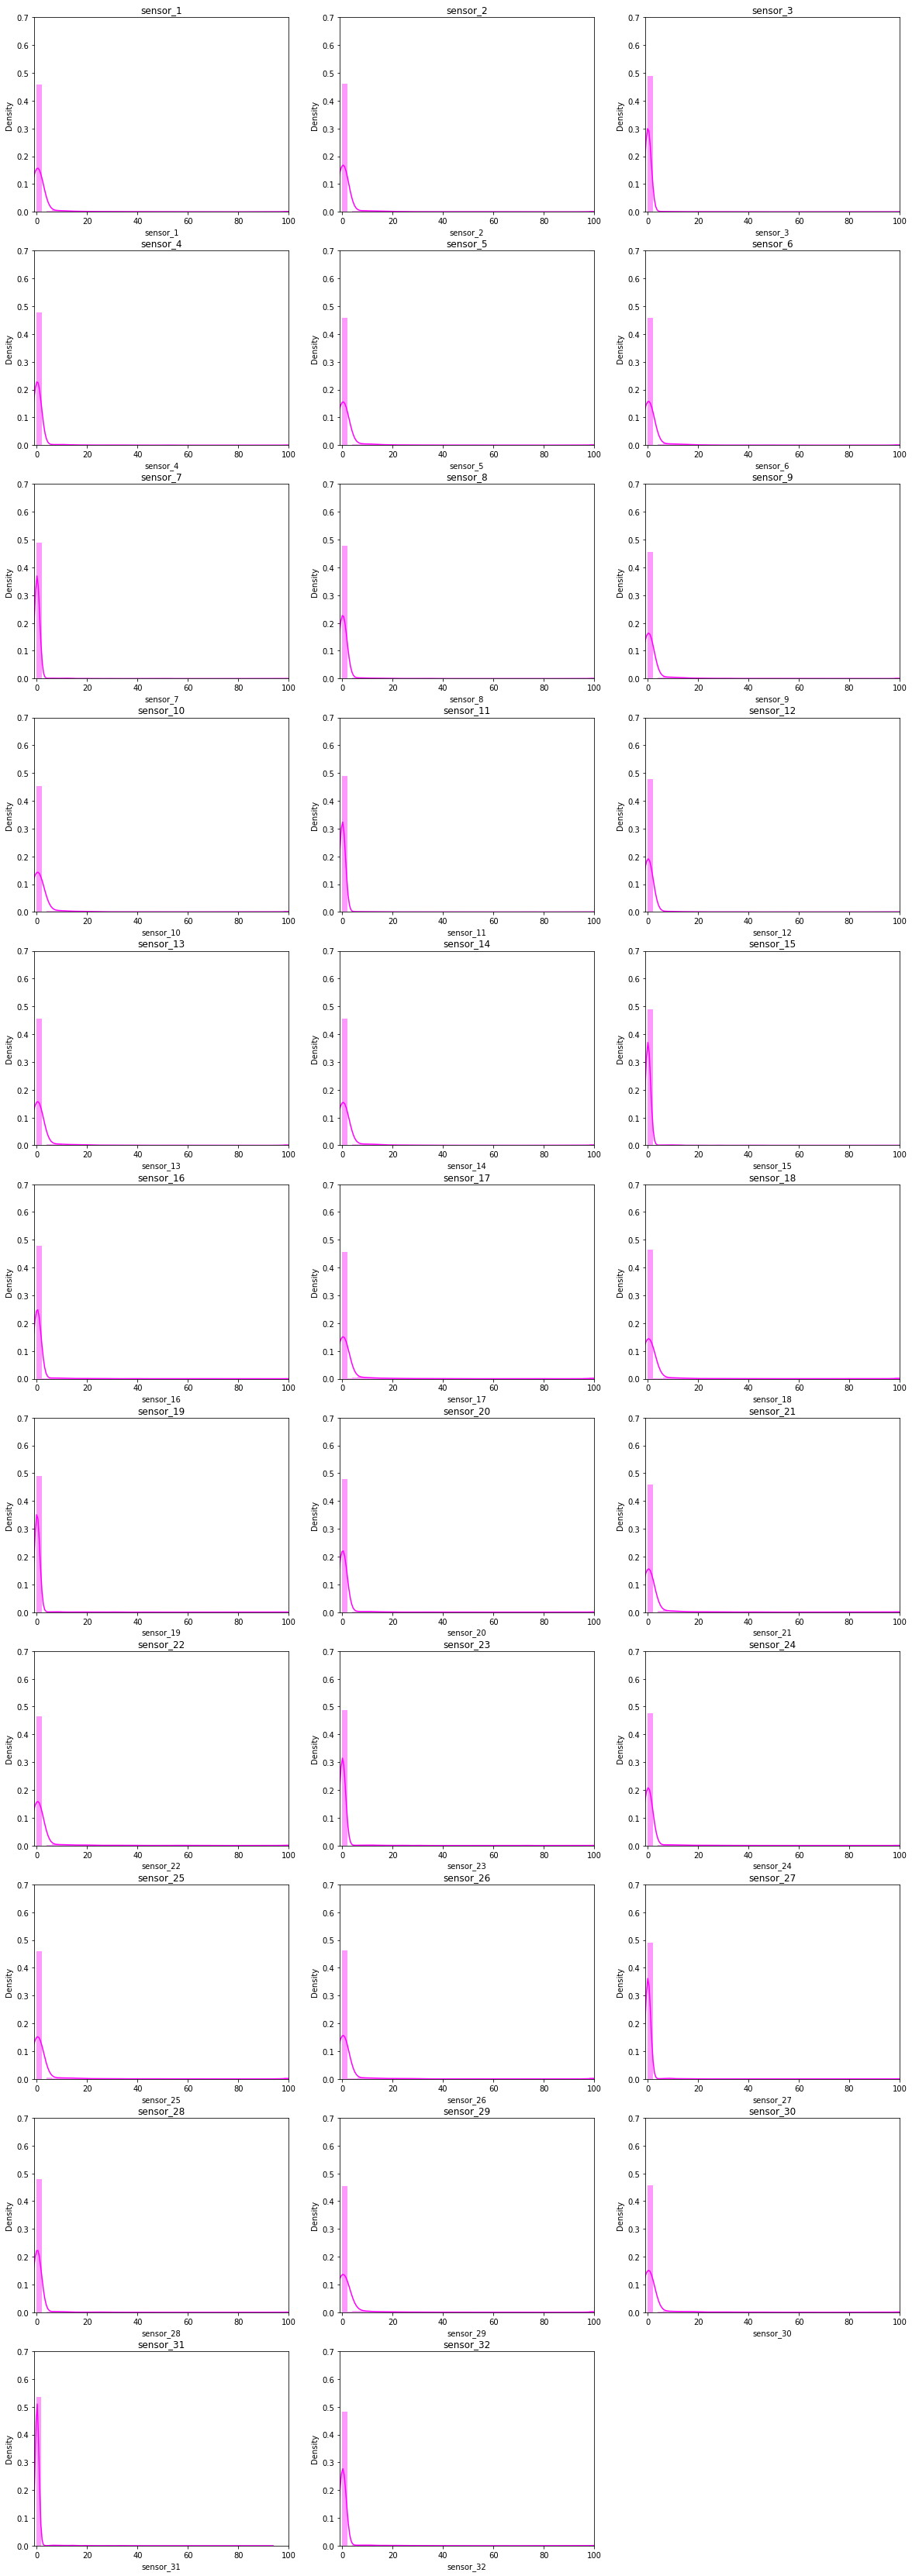

In [ ]:
# 각 센서별 분포그래프 그리기
feature = train_X.columns
plt.figure(figsize=(20,60))

for i in range(len(feature)):
    plt.subplot(11,3,i+1)
    plt.title(feature[i])
    plt.xlim(-1,100)
    plt.ylim(0,0.7)
    sns.distplot(train_X[feature[i]],color='magenta')
plt.show()

### New feature -> 약간의 상승 확인

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')
train_X = train.drop(['id','target'],axis=1)
train_y = train.target

test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')
test_X = test.drop(['id'], axis=1)

In [ ]:
def new_feature(df):
    df['feature_1'] = (df['sensor_2']+df['sensor_4']+df['sensor_6']+df['sensor_8']+df['sensor_10']+df['sensor_12']
                        +df['sensor_14']+df['sensor_16']+df['sensor_18']+df['sensor_20']+df['sensor_22']
                        +df['sensor_24']+df['sensor_26']+df['sensor_28']+df['sensor_30']+df['sensor_32'])
    df['feature_2'] = (df['sensor_1']+df['sensor_5']+df['sensor_9']+df['sensor_13']+df['sensor_17']+df['sensor_21']
                       +df['sensor_25']+df['sensor_29'])
    df['feature_3'] = (df['sensor_3']+df['sensor_7']+df['sensor_11']+df['sensor_15']+df['sensor_19']+df['sensor_23']
                       +df['sensor_27']+df['sensor_31'])
    return df

In [ ]:
train_X = new_feature(train_X)

In [ ]:
test_X = new_feature(test_X)

In [ ]:
train_X

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,feature_1,feature_2,feature_3
0,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,4.145636,...,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822,-13.705184,-8.216703,12.962826
1,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,-4.060134,...,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421,-42.160861,-1.097178,35.765666
2,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,-5.975194,...,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090,-49.950992,13.199849,-50.273697
3,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,2.099845,...,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077,-5.498592,-6.505999,-2.967353
4,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,-4.000506,...,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846,-2.740559,16.812735,-68.388225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,-3.971043,39.913391,16.034626,-19.067697,8.061361,-70.916786,-39.937026,12.834223,-21.937973,14.942994,...,-11.106802,-37.863399,31.069292,-4.097017,-13.095192,-5.150284,8.016265,5.526964,-25.652691,-2.059720
2331,-3.011710,-4.060355,-1.046067,4.178137,-2.003243,-2.895017,-2.766757,-29.099123,-4.208953,-4.793855,...,-0.867018,23.892336,-11.977934,1.984203,0.891666,28.822082,-0.878670,-24.595070,-12.390462,70.989029
2332,-9.001824,5.985711,-8.146347,-10.902201,5.102105,8.133692,32.877614,-3.017438,-3.174442,-5.724941,...,-5.825790,-37.989569,15.014132,1.160272,-11.135889,-7.035763,-0.930067,-20.303901,-4.698644,-11.344382
2333,-3.987992,3.011460,-11.949323,-3.810885,16.880234,-5.150117,9.182801,4.960190,-21.002525,-1.881519,...,-1.052350,-6.019488,-7.075333,-5.826058,-3.989168,14.916905,-12.093426,-33.124669,-12.012439,35.048533


### Decision Tree ML stacking model

In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random
%matplotlib inline

import xgboost
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

In [ ]:
CFG = {
    'name':'stacking_fin_est_xgb'
}

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/train.csv')
train_X = train.drop(['id','target'],axis=1)
train_y = train.target

test = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/data/test.csv')
test_X = test.drop(['id'], axis=1)

In [ ]:
skf = StratifiedKFold(n_splits = 10, random_state = 2022, shuffle = True) 

In [ ]:
rnd_clf = RandomForestClassifier(random_state=2022) # RandomForest #모델을 객체에 할당
lgbm_clf = LGBMClassifier(random_state=2022)
xgb_clf = XGBClassifier(random_state=2022)
stacking_clf = StackingClassifier(estimators = [('rnd', rnd_clf),
                                                ('lgbm', lgbm_clf), 
                                                ('xgb', xgb_clf)
                                                ],
                                  cv = StratifiedKFold(n_splits=5, random_state=2022, shuffle=True),
                                  final_estimator = XGBClassifier(random_state=2022)
                                  )

In [ ]:
# pandas를 np 로 바꿔주는 작업
train_X = np.array(train_X)
train_y = np.array(train_y)

test_X = np.array(test_X)

In [ ]:
acc_mean = 0.0
pred_ensemble = np.zeros([9343, 4])

for i, (train_idx, valid_idx) in enumerate(skf.split(train_X, train_y)):
    print(f'{i+1} Fold Trainign...')
    tr_x, tr_y = train_X[train_idx], train_y[train_idx]
    val_x, val_y = train_X[valid_idx], train_y[valid_idx]

    stacking_clf.fit(tr_x, tr_y)
    val_pred = stacking_clf.predict(val_x)
    acc_tmp = accuracy_score(val_y, val_pred)
    print(f'{i+1} Fold Acc : {acc_tmp}')

    pred = stacking_clf.predict_proba(test_X)
    acc_mean += (acc_tmp / skf.n_splits)
    pred_ensemble += (pred / skf.n_splits)


1 Fold Trainign...
1 Fold Acc : 0.8418803418803419
2 Fold Trainign...
2 Fold Acc : 0.8461538461538461
3 Fold Trainign...
3 Fold Acc : 0.8504273504273504
4 Fold Trainign...
4 Fold Acc : 0.8162393162393162
5 Fold Trainign...
5 Fold Acc : 0.8290598290598291
6 Fold Trainign...
6 Fold Acc : 0.8197424892703863
7 Fold Trainign...
7 Fold Acc : 0.8283261802575107
8 Fold Trainign...
8 Fold Acc : 0.8240343347639485
9 Fold Trainign...
9 Fold Acc : 0.8240343347639485
10 Fold Trainign...
10 Fold Acc : 0.8240343347639485


In [ ]:
# 결과 확인
print(np.argmax(pred_ensemble, axis = 1))
print(acc_mean)
pred_ensemble

[0 0 1 ... 2 0 3]
0.8303932357580427


array([[0.9250387 , 0.00690726, 0.00596716, 0.0620869 ],
       [0.92138313, 0.00280164, 0.00481941, 0.07099583],
       [0.01211634, 0.87620357, 0.03688476, 0.07479531],
       ...,
       [0.23977841, 0.00338214, 0.74295316, 0.01388629],
       [0.97818769, 0.00137591, 0.00204821, 0.01838822],
       [0.00107455, 0.02327882, 0.00214827, 0.97349837]])

In [ ]:
# 결과확인
submission['target'] = np.argmax(pred_ensemble, axis = 1)
submission.target.value_counts()

2    2431
1    2430
0    2308
3    2174
Name: target, dtype: int64

In [ ]:
submission.to_csv(f'/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/pred_record/{CFG["name"]}.csv', index = False)

### CNN + TREE ML 앙상블

In [ ]:
weights = np.array([1, 1.2, 0.9, 1.1])

In [ ]:
cnn_tree_cross = (cnn_pred + pred_ensemble) * weights / 2

In [ ]:
submission['target'] = np.argmax(cnn_tree_cross, axis = 1)
submission.target.value_counts()

3    2361
2    2351
0    2322
1    2309
Name: target, dtype: int64

In [ ]:
# 결과 비교
'''
CNN + Stacking Ensemble + weights [1, 1.2, 0.9, 1.1]
3    2361
2    2351
0    2322
1    2309

CNN + Stacking Ensemble
2    2413
3    2363
0    2326
1    2241

CNN
3    2488
2    2406
0    2341
1    2108

Stacking_final_estimator = XGB + new feature
2    2432
1    2428
0    2307
3    2176

Stacking_final_estimator = XGB
1    2508
2    2422
0    2314
3    2099

Stacking_final_estimator = LGBM
1    2475
2    2425
0    2307
3    2136

Decision Tree 앙상블(stacking_final_estimator =Rnd Forest)
1    2474
2    2418
0    2338
3    2113

그냥 실행
2    2414
1    2410
0    2314
3    2205

randomstate=2022
2    2470
1    2315
3    2302
0    2256

stacking_clf에서 final_estimator :lgbm -> rnd

2    2501
1    2372
3    2246
0    2224
'''

### CNN + Tree + MLP 앙상블

In [ ]:
ensemble_three_model = (1.2*cnn_pred + 1.1*pred_ensemble + 0.7*b.cpu().detach().numpy()) / 3

In [ ]:
submission['target'] = np.argmax(ensemble_three_model, axis = 1)
submission.target.value_counts()

1    2445
2    2444
0    2271
3    2183
Name: target, dtype: int64

In [ ]:
'''
CNN
2    2446
0    2420
1    2413
3    2064

Tree
2    2431
1    2430
0    2308
3    2174

MLP
1    2433
2    2383
3    2303
0    2224

Ensemble
2    2431
1    2428
0    2245
3    2239

Ensemble weight(1.2 1.1 0.7)
1    2445
2    2444
0    2271
3    2183
'''

In [ ]:
submission.to_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_16.csv', index = False)

### 결과 비교

In [ ]:
# 결과 확인
print(np.argmax(cnn_pred, axis = 1))
print(np.mean(cnn_acc))
cnn_pred

[0 0 1 ... 0 0 3]
0.8188034188034188


array([[9.86677818e-01, 7.81249665e-03, 1.95414558e-03, 3.55556470e-03],
       [9.96157885e-01, 1.11082025e-04, 9.08714290e-04, 2.82231425e-03],
       [3.12281959e-01, 5.71664271e-01, 1.00656077e-01, 1.53976977e-02],
       ...,
       [7.74978034e-01, 1.79678777e-03, 1.98333929e-01, 2.48912369e-02],
       [9.96756807e-01, 4.99412072e-05, 8.20358005e-04, 2.37290690e-03],
       [3.21774011e-04, 5.54715760e-02, 2.49065116e-02, 9.19300109e-01]])

In [ ]:
'''
비교
BASE : 8-fold / 0.84069 / 리더보드 0.88353
Weight init He / 0.82868 /
val loss 로 변경 / 0.81411 / 
optimizer : SGD / 0.84369 / 리더보드 0.87518 / 9343 중 BASE와 548개 다름
4 * 8 로 변경 / 0.81970 /
코드공유 max pooling 사용안함 / 0.82442 / 
activation : Relu로 변경 / 0.82399
conv_2 : 16->32 / 0.84111
conv_1 : 8->16 , conv_2 : 16->32 / 0.84669 / 리더보드 /BASE와 464개 다름
dropout 0.2 적용 / 0.83770 / 
rows 별로 minmax scaling / 0.68953 /
 max pooling 사용안함 / 0.85482
위 조건에서 8 fold -> 10 / 0.85051
fake_sensor 4개 - 0값 -150줘도 고만고만함/ 0.79272
처음 conv layer 64채널, stratified shuffle split으로 바꿔줌 10 fold / 0.84957
Stacking_RndForest 10Fold / 0.82527 / 
Stacking_XGB 10Fold / 0.82697
Stacking_XGB 10Fold + new feature / 0.83082
CNN + Stacking / 리더보드 0.88396/
CNN + Stacking + weights / 리더보드 0.88717 /
CNN + 8*8 로변경 + Layer 하나 축소 / 0.83760 / 큰 변화 는 없음
CNN + 8*8 로변경 + Layer 하나 축소 + dropout(0.5) / 0.82393 / dropout높이면 손해
CNN + 8*8 로변경 + Layer 하나 축소 + Adam / 0.84188 /
위에서 Adam(lr=0.001) + val_loss 기준 모델 / 0.82521 /
CNN Basic + 5 Fold / 0.80257 / 리더보드 0.8285 /
Batch size 변경
'''

In [ ]:
compare_sub = pd.read_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission/submit_10.csv')

In [ ]:
submission[submission['target']!=compare_sub['target']].shape

(7017, 2)

In [ ]:
submission.target.value_counts()

2    2441
3    2378
1    2314
0    2210
Name: target, dtype: int64

In [ ]:
submission.to_csv('/content/drive/MyDrive/AI_individual/Dacon_hand_gesture/submission_2nd/submit_2.csv', index = False)